In [1]:
from pathlib import Path
import pandas as pd
from helpers.benchmark import load_records_from_directory, filter_full_lifecycle, trim_on_benchmark
from helpers.alibaba import inject_billed_alibaba, load_all_billed_alibaba
from helpers.aws import inject_billed_aws, load_all_billed_aws
from helpers.azure import inject_billed_azure, load_all_billed_azure
from helpers.gcp import inject_billed_gcp, load_all_billed_gcp
from helpers.benchmark import load_records_from_directory, filter_full_lifecycle, trim_on_benchmark


LOG_DIR = "data/stage_c"
PARQUET_CACHE = "cache/stage_c.parquet"

LOCAL_WEEK_START = "2025-12-01"
LOCAL_WEEK_END   = "2025-12-08"

BENCHMARK_LABEL = {"gemm": "MatMul", "sha256": "SHA-256", "aesCtr": "AES-CTR", "gzip": "Gzip", "json": "JSON"}

cache_path = Path(PARQUET_CACHE)
if cache_path.exists():
    print(f"Loading cached dataframe from {cache_path} ...")
    df_raw = pd.read_parquet(cache_path)
else:
    print("Cache not found – loading from raw directory ...")
    df_raw = load_records_from_directory(LOG_DIR)
    print(f"Loaded {len(df_raw)} total records from Stage C experiments.")
    cache_path.parent.mkdir(parents=True, exist_ok=True)
    df_raw.to_parquet(cache_path, index=False)
    print(f"Wrote cache to {cache_path}")

df_raw = df_raw.copy()
df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"], utc=True)
# US East providers: filter in America/New_York timezone
df_us_east_local = df_raw[
    (df_raw["provider"].isin(["aws", "gcp", "alibaba"])) &
    (df_raw["timestamp"].dt.tz_convert("America/New_York") >= pd.Timestamp(LOCAL_WEEK_START, tz="America/New_York")) &
    (df_raw["timestamp"].dt.tz_convert("America/New_York") <  pd.Timestamp(LOCAL_WEEK_END,   tz="America/New_York"))
].copy()

# Azure: filter in Europe/Berlin timezone
df_berlin_local = df_raw[
    (df_raw["provider"] == "azure") &
    (df_raw["timestamp"].dt.tz_convert("Europe/Berlin") >= pd.Timestamp(LOCAL_WEEK_START, tz="Europe/Berlin")) &
    (df_raw["timestamp"].dt.tz_convert("Europe/Berlin") <  pd.Timestamp(LOCAL_WEEK_END,   tz="Europe/Berlin"))
].copy()

df_time_trimmed = pd.concat([df_us_east_local, df_berlin_local], ignore_index=True)

print("Rows total:", len(df_raw))
print("Rows after LOCAL week filter (provider-aware):", len(df_time_trimmed))



BENCHMARKS = ["gemm", "sha256", "json", "gzip", "aesCtr"]

STAGE_C_CONFIGS = [
    ("aws", 512, BENCHMARKS),
    ("gcp", 512, BENCHMARKS),
    ("alibaba", 512, BENCHMARKS),
    ("azure", 512, BENCHMARKS),
]

df = filter_full_lifecycle(df_time_trimmed,remove_cold=True)


# billed_alibaba_df = load_all_billed_alibaba(f"{LOG_DIR}/billed/alibaba")
# df = inject_billed_alibaba(df, billed_alibaba_df)

# billed_azure_df = load_all_billed_azure(f"{LOG_DIR}/billed/azure")
# df = inject_billed_azure(df, billed_azure_df)

# billed_gcp_df = load_all_billed_gcp(f"{LOG_DIR}/billed/gcp")
# df = inject_billed_gcp(df, billed_gcp_df)

# billed_aws_df = load_all_billed_aws(f"{LOG_DIR}/billed/aws")
# df = inject_billed_aws(df, billed_aws_df)


allowed = {
    (p, mem, b)
    for (p, mem, benchmarks) in STAGE_C_CONFIGS
    for b in benchmarks
}
df = df[
    df.apply(lambda row: (row["provider"], row["memory_size_mb"], row["benchmark_type"]) in allowed, axis=1)
].copy()



# as experiments were conducted at 23:00 UTC and experiments run longer than an hour
# we shift by +1h, then floor to 6h bins, then shift back -1h
def _slot_bin_stage_c_utc(ts: pd.Series) -> pd.Series:
    ts = pd.to_datetime(ts, utc=True)
    return (ts + pd.Timedelta(hours=1)).dt.floor("6h") - pd.Timedelta(hours=1)
df["slot_utc"] = _slot_bin_stage_c_utc(df["timestamp"])


def _provider_local_tz(provider: str) -> str:
    return "Europe/Berlin" if provider == "azure" else "America/New_York"

df["local_tz"] = df["provider"].apply(_provider_local_tz)
df["slot_local"] = df.apply(lambda row: row["slot_utc"].tz_convert(row["local_tz"]), axis=1 )




outlier_trimmed_df = pd.DataFrame()
for provider, mem_size, benchmarks in STAGE_C_CONFIGS:
    for benchmark in benchmarks:
        config_df = df[
            (df["provider"] == provider) &
            (df["memory_size_mb"] == mem_size) &
            (df["benchmark_type"] == benchmark)
        ].copy()
        trimmed_config_df = trim_on_benchmark(config_df, group_on_timestamp=True, benchmark=benchmark)
        outlier_trimmed_df = pd.concat([outlier_trimmed_df, trimmed_config_df], ignore_index=True)
        


print(f"\nRows after CPU filtering: {len(df)}")
print("\nRecords per provider:")
print(df.groupby(["provider"]).size())
trimmed_df = outlier_trimmed_df.copy()
print(f"\nRows after outlier trimming: {len(trimmed_df)}")
print("\nRecords per provider:")
print(trimmed_df.groupby(["provider"]).size())

Loading cached dataframe from cache/stage_c.parquet ...
Rows total: 1790501
Rows after LOCAL week filter (provider-aware): 1392567

Rows after CPU filtering: 809934

Records per provider:
provider
alibaba    188889
aws        178029
azure      235473
gcp        207543
dtype: int64

Rows after outlier trimming: 800737

Records per provider:
provider
alibaba    186802
aws        175851
azure      232923
gcp        205161
dtype: int64


Saved: plots/stage_c/cpu_composition_over_time/cpu_composition_over_time_aws_512mb.pdf


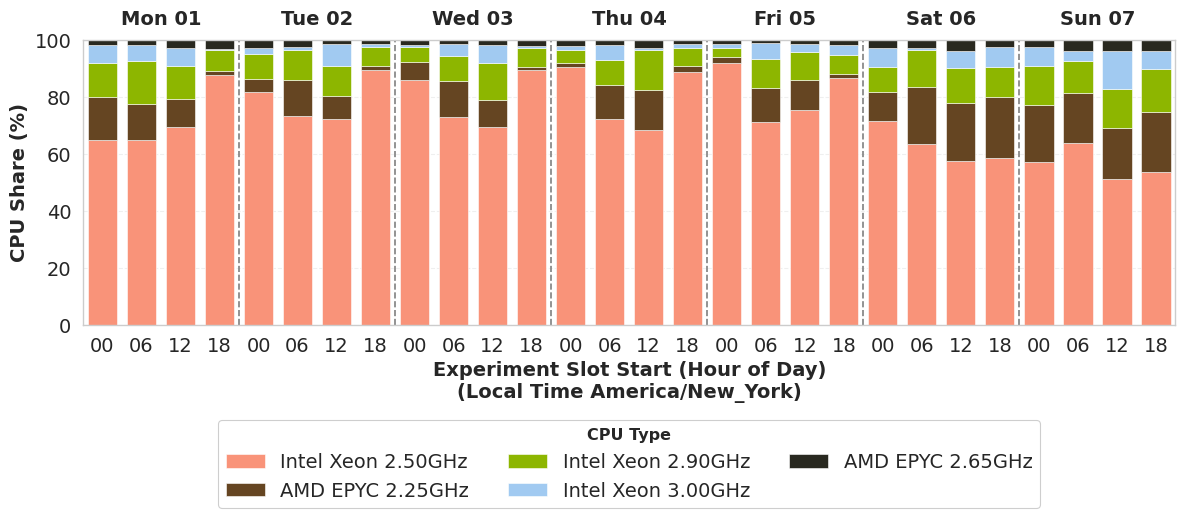

Saved: plots/stage_c/cpu_composition_over_time/cpu_composition_over_time_azure_512mb.pdf


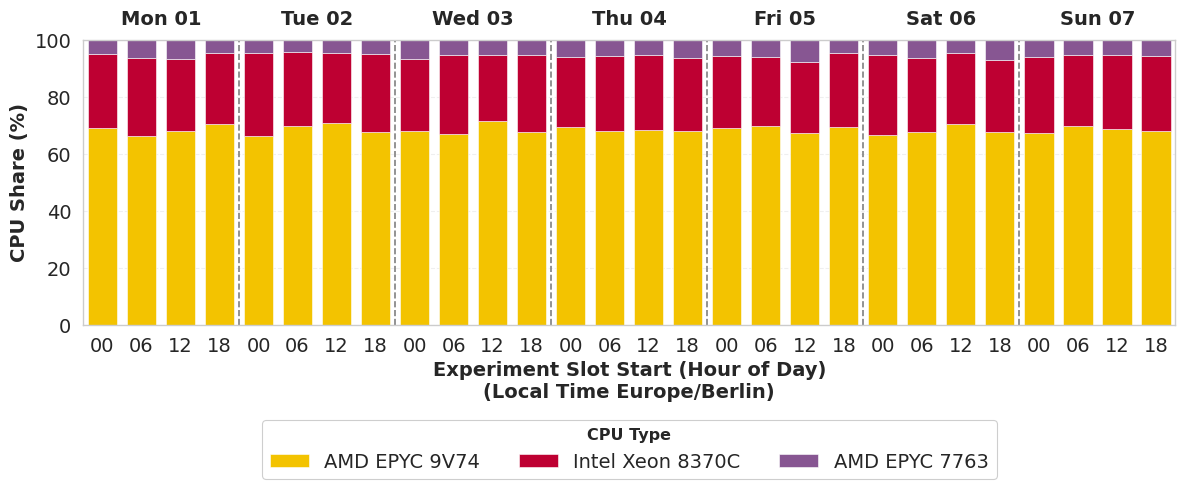

Saved: plots/stage_c/cpu_composition_over_time/cpu_composition_over_time_gcp_512mb.pdf


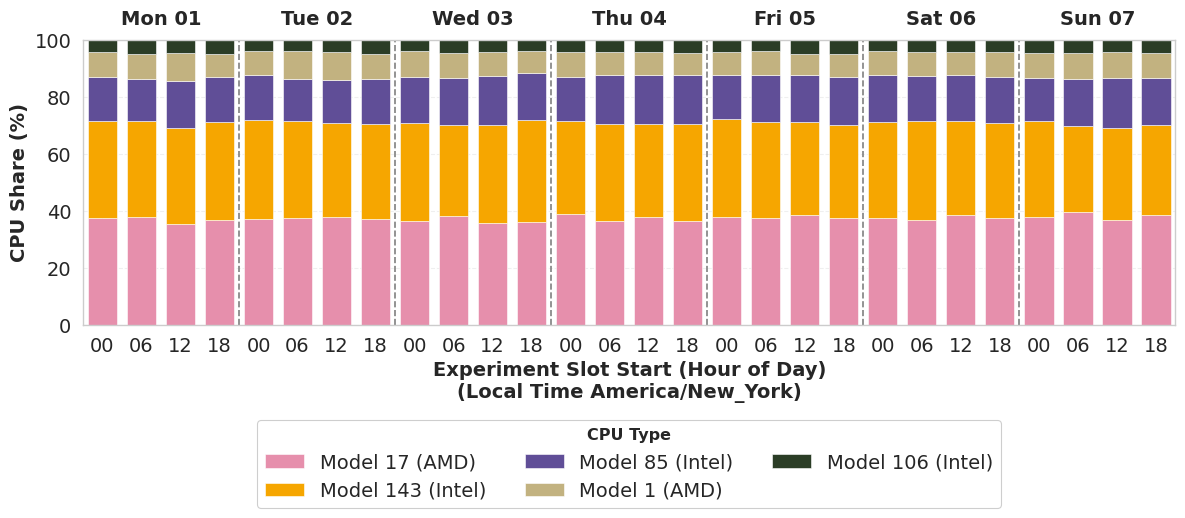

Saved: plots/stage_c/cpu_composition_over_time/cpu_composition_over_time_alibaba_512mb.pdf


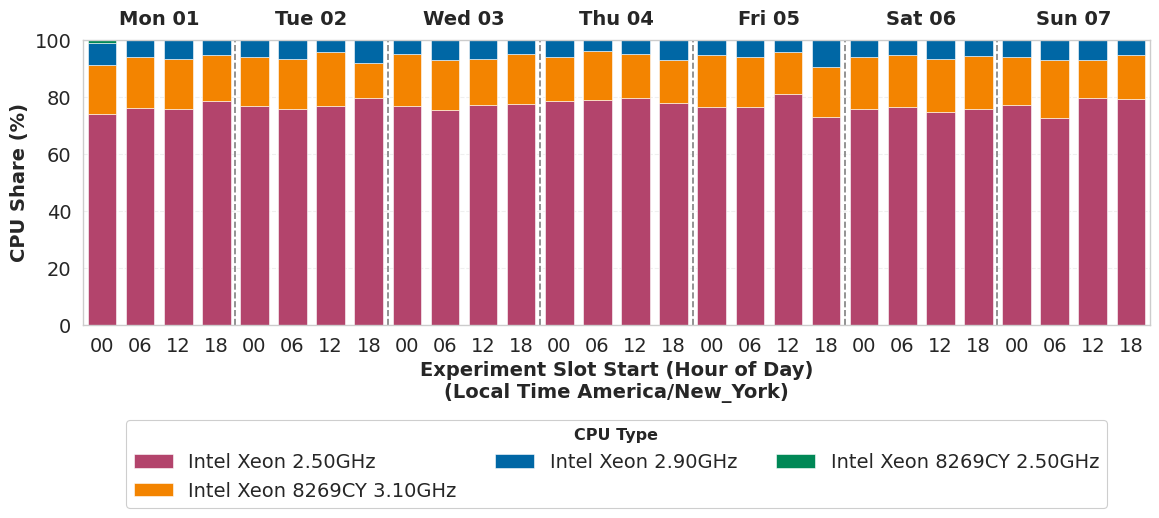

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from helpers.cpus import shorten_cpu_name, get_cpu_palette

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def plot_cpu_composition_over_time(
    df: pd.DataFrame,
    provider: str,
    memory_size: int = 512,
    benchmarks: list[str] | None = None,
    save_dir: str = "../holy/graphs/StageC",
):

    d = df[
        (df["provider"] == provider)
        & (df["memory_size_mb"] == memory_size)
        & (df["benchmark_type"].isin(benchmarks))
    ].copy()

    tz = "Europe/Berlin" if provider.lower() == "azure" else "America/New_York"

    d = d.sort_values("slot_local")
    unique_slots = pd.Index(d["slot_local"].unique()).sort_values()
    slot_to_idx = {slot: i for i, slot in enumerate(unique_slots)}
    d["slot_idx"] = d["slot_local"].map(slot_to_idx)

    dist_counts = d.groupby(["slot_idx", "cpu_type"]).size().unstack(fill_value=0)
    dist_pct = dist_counts.div(dist_counts.sum(axis=1), axis=0) * 100.0

    cpu_order = dist_counts.sum(axis=0).sort_values(ascending=False).index.tolist()
    dist_pct = dist_pct.reindex(columns=cpu_order)

    palette = get_cpu_palette(cpu_order, provider=provider)

    time_labels = unique_slots.strftime("%H")
    local_days = pd.Series(unique_slots.date)
    
    day_bounds = {}
    for i, day in enumerate(local_days):
        day_bounds.setdefault(day, []).append(i)

    fig, ax = plt.subplots(figsize=(12, 5))

    bottom = np.zeros(len(dist_pct))
    for cpu in dist_pct.columns:
        heights = dist_pct[cpu].values
        ax.bar(
            dist_pct.index,
            heights,
            bottom=bottom,
            width=0.75,
            color=palette.get(cpu, "#333333"),
            edgecolor="white",
            linewidth=0.4,
            label=cpu
        )
        bottom += heights

    ax.set_ylabel("CPU Share (%)", fontweight="bold", fontsize=14)
    ax.set_ylim(0, 100)

    x = np.arange(len(unique_slots))
    ax.set_xticks(x)
    ax.set_xticklabels(time_labels, fontsize=14)
    ax.set_xlabel(f"Experiment Slot Start (Hour of Day)\n(Local Time {tz})", fontweight="bold", fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=14)

    # Day separators and day labels
    for day, idxs in day_bounds.items():
        center = (idxs[0] + idxs[-1]) / 2
        ax.text(center, 104, pd.Timestamp(day).strftime("%a %d"),
                ha="center", va="bottom", fontsize=14, fontweight="bold")
        if idxs[0] > 0:
            ax.axvline(idxs[0] - 0.5, color="gray", linestyle="--", linewidth=1.2, alpha=1)

    ax.grid(True, axis="y", linestyle="--", alpha=0.3)
    ax.set_xlim(-0.5, len(unique_slots) - 0.5)

    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend(
        handles, labels,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.3),
        ncol=min(3, len(cpu_order)),
        fontsize=14,
        framealpha=0.95,
        title="CPU Type",
    )
    leg.get_title().set_fontweight("bold")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.28)

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, f"cpu_composition_over_time_{provider}_{memory_size}mb.pdf")
        plt.savefig(out_path, bbox_inches="tight", format="pdf")
        print(f"Saved: {out_path}")

    plt.show()
for provider in ["aws", "azure", "gcp", "alibaba"]:
    plot_cpu_composition_over_time(
        df,
        provider,
        memory_size=512,
        benchmarks=["gemm", "sha256", "json", "gzip", "aesCtr"],
        save_dir="plots/stage_c/cpu_composition_over_time"
    )


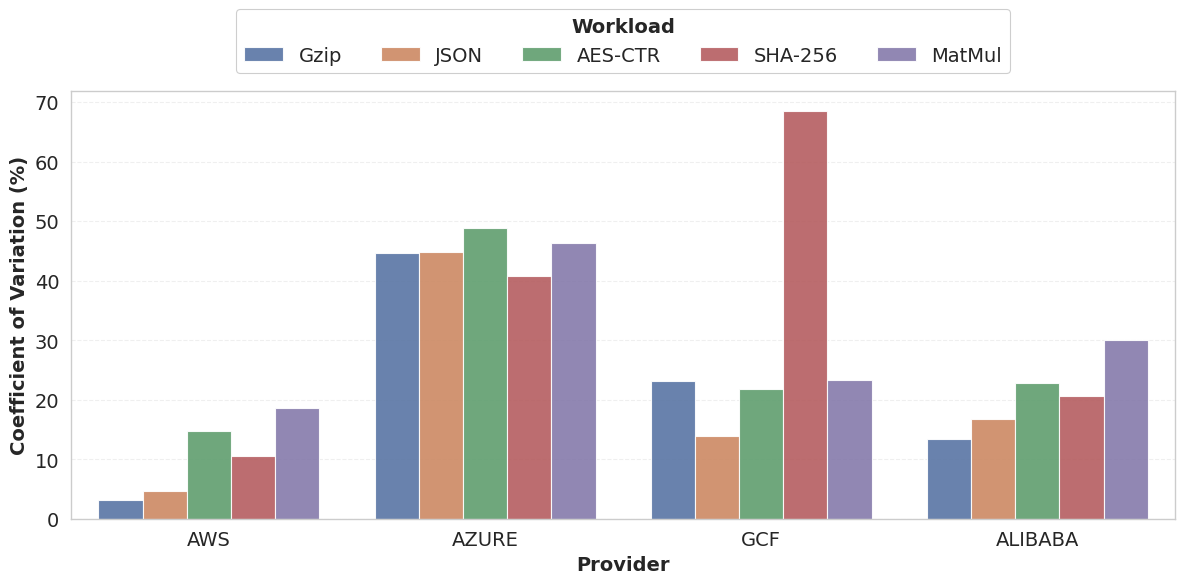


CV results:
   Provider Workload         CV
17  ALIBABA  AES-CTR  22.839157
18  ALIBABA     Gzip  13.489794
19  ALIBABA     JSON  16.716507
15  ALIBABA   MatMul  30.025282
16  ALIBABA  SHA-256  20.587264
2       AWS  AES-CTR  14.746277
3       AWS     Gzip   3.233717
4       AWS     JSON   4.731852
0       AWS   MatMul  18.677517
1       AWS  SHA-256  10.529221
7     AZURE  AES-CTR  48.920512
8     AZURE     Gzip  44.727122
9     AZURE     JSON  44.876173
5     AZURE   MatMul  46.380644
6     AZURE  SHA-256  40.871640
12      GCF  AES-CTR  21.807623
13      GCF     Gzip  23.127016
14      GCF     JSON  13.874578
10      GCF   MatMul  23.302006
11      GCF  SHA-256  68.475174
Saved CV comparison to plots/stage_c/cv_comparison.pdf

Eta-squared results:
   Provider Workload   eta2_pct
17  ALIBABA  AES-CTR  47.691702
18  ALIBABA     Gzip  24.842911
19  ALIBABA     JSON  21.401402
15  ALIBABA   MatMul  46.317330
16  ALIBABA  SHA-256  79.675988
2       AWS  AES-CTR  76.313460
3       AWS   

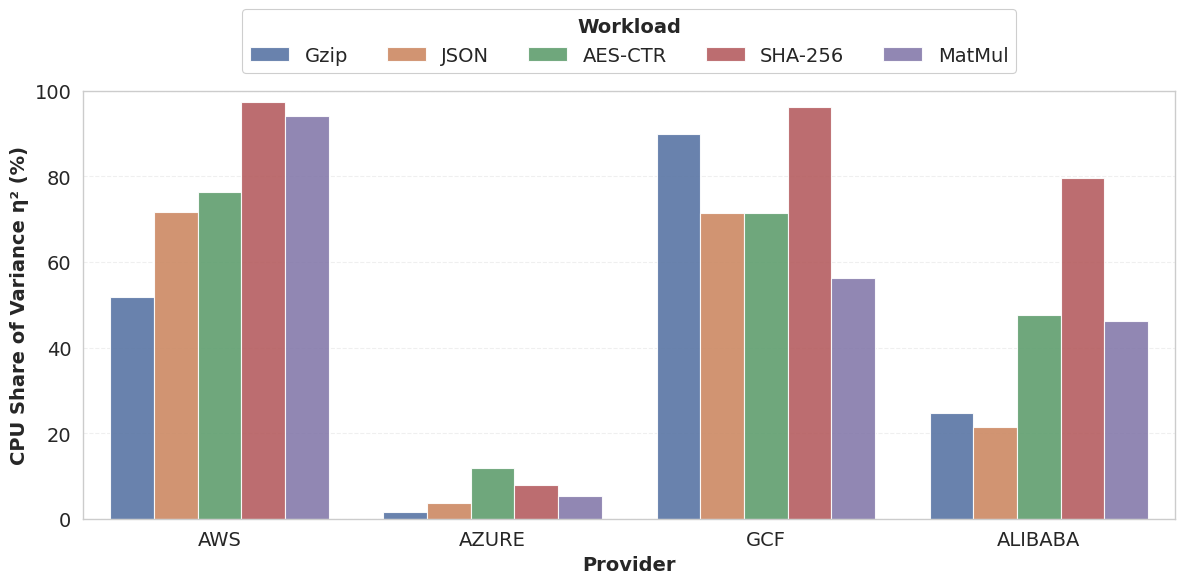

Saved eta-squared comparison to plots/stage_c/eta2_comparison.pdf


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from helpers.benchmark import metric_for_benchmark
from statsmodels.formula.api import ols

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


PROVIDERS = ["aws", "azure", "gcp", "alibaba"]
WORKLOAD_ORDER = ["Gzip", "JSON", "AES-CTR", "SHA-256", "MatMul"]


def plot_cv_by_provider(trimmed_df, output_path='cv_comparison.pdf'):
    cv_data = []
    for provider in PROVIDERS:
        for benchmark, label in BENCHMARK_LABEL.items():
            sub = trimmed_df[
                (trimmed_df['provider'] == provider) &
                (trimmed_df['benchmark_type'] == benchmark)
            ].copy()
            metric = metric_for_benchmark(benchmark)
            cv = (sub[metric].std() / sub[metric].mean()) if len(sub) > 0 else np.nan
            cv_data.append({
                'Provider': "GCF" if provider == "gcp" else provider.upper(),
                'Workload': label,
                'CV': cv * 100  # Convert to percentage
            })
    
    df = pd.DataFrame(cv_data)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.barplot(
        data=df, 
        x='Provider', 
        y='CV', 
        hue='Workload', 
        hue_order=WORKLOAD_ORDER,
        ax=ax,
        linewidth=0.8, 
        alpha=0.9
    )
    
    ax.set_xlabel('Provider', fontsize=14, fontweight='bold')
    ax.set_ylabel('Coefficient of Variation (%)', fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', labelsize=14)
    
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    
    ax.legend(
        title='Workload',
        fontsize=14,
        ncol=5,    
        title_fontsize=14,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.02),  
        framealpha=0.95,
    )
    ax.get_legend().get_title().set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight', format='pdf')
    plt.show()
    plt.close()

    print("\nCV results:")
    print(df.sort_values(['Provider', 'Workload']))
    
    print(f"Saved CV comparison to {output_path}")


def calculate_eta2_cpu(df, provider, benchmark, memory_size=512):
    """
    Calculate single-factor eta-squared for CPU type on log(execution_time)
    """
    metric = metric_for_benchmark(benchmark)
    
    d = df[
        (df["provider"].str.lower() == provider.lower()) &
        (df["memory_size_mb"] == memory_size) &
        (df["benchmark_type"] == benchmark)
    ].copy()
    
    d = d.dropna(subset=["cpu_type", metric])
    d["execution_time_ms"] = pd.to_numeric(d[metric], errors="coerce")
    d = d.dropna(subset=["execution_time_ms"])


    if (d["execution_time_ms"] <= 0).any():
        return np.nan
    
    # Log transform
    d["log_exec_time"] = np.log(d["execution_time_ms"])
    
    # Calculate eta-squared: SS_cpu / SS_total
    y = d["log_exec_time"].to_numpy(float)
    ss_total = float(((y - y.mean()) ** 2).sum())

    # Fit model: log_exec_time ~ cpu_type
    model = ols("log_exec_time ~ C(cpu_type, Sum)", data=d).fit()
    ss_error = float((model.resid ** 2).sum())
    ss_cpu = max(ss_total - ss_error, 0.0)
    
    eta2 = ss_cpu / ss_total
    return eta2 * 100.0  # return as percentage

def plot_eta2_comparison(df, memory_size=512, output_path='eta2_comparison.pdf'):
    """
    Plot eta-squared comparison across providers (same style as CV plot)
    """
    # Compute eta-squared for all combinations
    results = []
    for provider in PROVIDERS:
        for benchmark, label in BENCHMARK_LABEL.items():
            eta2_pct = calculate_eta2_cpu(df, provider, benchmark, memory_size)
            results.append({
                'Provider': "GCF" if provider == "gcp" else provider.upper(),
                'Workload': label,
                'eta2_pct': eta2_pct
            })
    
    eta2_df = pd.DataFrame(results)
    print("\nEta-squared results:")
    print(eta2_df.sort_values(['Provider', 'Workload']))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.barplot(
        data=eta2_df,
        x='Provider',
        y='eta2_pct',
        hue='Workload',
        hue_order=WORKLOAD_ORDER,
        ax=ax,
        linewidth=0.8,
        alpha=0.9
    )
    
    ax.set_xlabel('Provider', fontsize=14, fontweight='bold')
    ax.set_ylabel('CPU Share of Variance η² (%)', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.tick_params(axis='both', labelsize=14)
    
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    
    ax.legend(
        title='Workload',
        fontsize=14,
        title_fontsize=14,
        framealpha=0.95,
        ncol=5,    
        loc="lower center",
        bbox_to_anchor=(0.5, 1.02),  
    )
    ax.get_legend().get_title().set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight', format='pdf')
    plt.show()
    plt.close()
    
    print(f"Saved eta-squared comparison to {output_path}")


plot_cv_by_provider(
    trimmed_df,
    output_path='plots/stage_c/cv_comparison.pdf'
)

plot_eta2_comparison(
    trimmed_df,
    memory_size=512,
    output_path='plots/stage_c/eta2_comparison.pdf'
)

In [4]:
# Key accelerators
KEY_FLAGS = {
    "sha_ni": "SHA-NI",
    "aes": "AES-NI", 
    "vaes": "VAES",
    "avx512f": "AVX512",
    "avx512ifma": "IFMA",
    "avx512_vnni": "VNNI",
}

def check_flag(flags, flag_name):
    if isinstance(flags, (list, np.ndarray)):
        return flag_name in flags
    return flag_name in str(flags).split()

# Build capability matrix
results = []
for provider in ["aws", "azure", "gcp", "alibaba"]:
    provider_df = df[df["provider"] == provider]
    
    for cpu in sorted(provider_df["cpu_type"].unique()):
        flags = provider_df[provider_df["cpu_type"] == cpu]["flags"].iloc[0]
        
        row = {"Provider": provider.upper(), "CPU": cpu}
        for flag, name in KEY_FLAGS.items():
            row[name] = "✅" if check_flag(flags, flag) else "❌"
        results.append(row)



cap_df = pd.DataFrame(results)

# Pretty print with pandas styling
pd.set_option('display.max_colwidth', 40)
pd.set_option('display.width', 120)
print(cap_df.to_markdown(index=False))

| Provider   | CPU                       | SHA-NI   | AES-NI   | VAES   | AVX512   | IFMA   | VNNI   |
|:-----------|:--------------------------|:---------|:---------|:-------|:---------|:-------|:-------|
| AWS        | AMD EPYC 2.25GHz          | ❌       | ✅       | ❌     | ❌       | ❌     | ❌     |
| AWS        | AMD EPYC 2.65GHz          | ❌       | ✅       | ❌     | ❌       | ❌     | ❌     |
| AWS        | Intel Xeon 2.50GHz        | ❌       | ✅       | ❌     | ❌       | ❌     | ❌     |
| AWS        | Intel Xeon 2.90GHz        | ❌       | ✅       | ❌     | ❌       | ❌     | ❌     |
| AWS        | Intel Xeon 3.00GHz        | ❌       | ✅       | ❌     | ❌       | ❌     | ❌     |
| AZURE      | AMD EPYC 7763             | ✅       | ✅       | ✅     | ❌       | ❌     | ❌     |
| AZURE      | AMD EPYC 9V74             | ✅       | ✅       | ✅     | ✅       | ✅     | ✅     |
| AZURE      | Intel Xeon 8370C          | ✅       | ✅       | ✅     | ✅       | ✅     | ✅     |
| GCP        | Mod

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.benchmark import metric_for_benchmark
from helpers.cpus import get_cpu_palette
import os

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def plot_workload_ecdf(df, provider, benchmark, label, output_path):

    
    # Filter data
    sub = df[
        (df['provider'] == provider) &
        (df['benchmark_type'] == benchmark)
    ].copy()
    
    if len(sub) == 0:
        print(f"No data for {provider} - {label}")
        return
    
    # Get metric and prepare data
    metric = metric_for_benchmark(benchmark)
    sub['Performance'] = sub[metric]
    
    # Get CPU order and palette
    cpu_counts = sub['cpu_type'].value_counts()
    cpu_order = cpu_counts.index.tolist()
    palette = get_cpu_palette(cpu_order, provider=provider)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.ecdfplot(data=sub, x='Performance', hue='cpu_type',
                hue_order=cpu_order,
                palette=palette,
                alpha=0.9,
                ax=ax, linewidth=2.5)
    
    # Customize
    ax.set_xlabel('Performance', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
    ax.set_title(f'{provider.upper()} - {label}', fontsize=14, fontweight='bold')
    ax.set_xlim(left=0)


    ax.grid(True, axis='both', linestyle='--', alpha=0.3)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Saved: {output_path}")

for provider, mem_size, benchmarks in STAGE_C_CONFIGS:
    for benchmark, label in BENCHMARK_LABEL.items():
        output_path = f'plots/stage_c/ecdfs/{provider}/ecdf_{benchmark}.pdf'
        plot_workload_ecdf(df, provider, benchmark, label, output_path)


Saved: plots/stage_c/ecdfs/aws/ecdf_gemm.pdf
Saved: plots/stage_c/ecdfs/aws/ecdf_sha256.pdf
Saved: plots/stage_c/ecdfs/aws/ecdf_aesCtr.pdf
Saved: plots/stage_c/ecdfs/aws/ecdf_gzip.pdf
Saved: plots/stage_c/ecdfs/aws/ecdf_json.pdf
Saved: plots/stage_c/ecdfs/gcp/ecdf_gemm.pdf
Saved: plots/stage_c/ecdfs/gcp/ecdf_sha256.pdf
Saved: plots/stage_c/ecdfs/gcp/ecdf_aesCtr.pdf
Saved: plots/stage_c/ecdfs/gcp/ecdf_gzip.pdf
Saved: plots/stage_c/ecdfs/gcp/ecdf_json.pdf
Saved: plots/stage_c/ecdfs/alibaba/ecdf_gemm.pdf
Saved: plots/stage_c/ecdfs/alibaba/ecdf_sha256.pdf
Saved: plots/stage_c/ecdfs/alibaba/ecdf_aesCtr.pdf
Saved: plots/stage_c/ecdfs/alibaba/ecdf_gzip.pdf
Saved: plots/stage_c/ecdfs/alibaba/ecdf_json.pdf
Saved: plots/stage_c/ecdfs/azure/ecdf_gemm.pdf
Saved: plots/stage_c/ecdfs/azure/ecdf_sha256.pdf
Saved: plots/stage_c/ecdfs/azure/ecdf_aesCtr.pdf
Saved: plots/stage_c/ecdfs/azure/ecdf_gzip.pdf
Saved: plots/stage_c/ecdfs/azure/ecdf_json.pdf


Saved: plots/stage_c/within_cpu_vs_overall_cv_by_workload_512mb.pdf


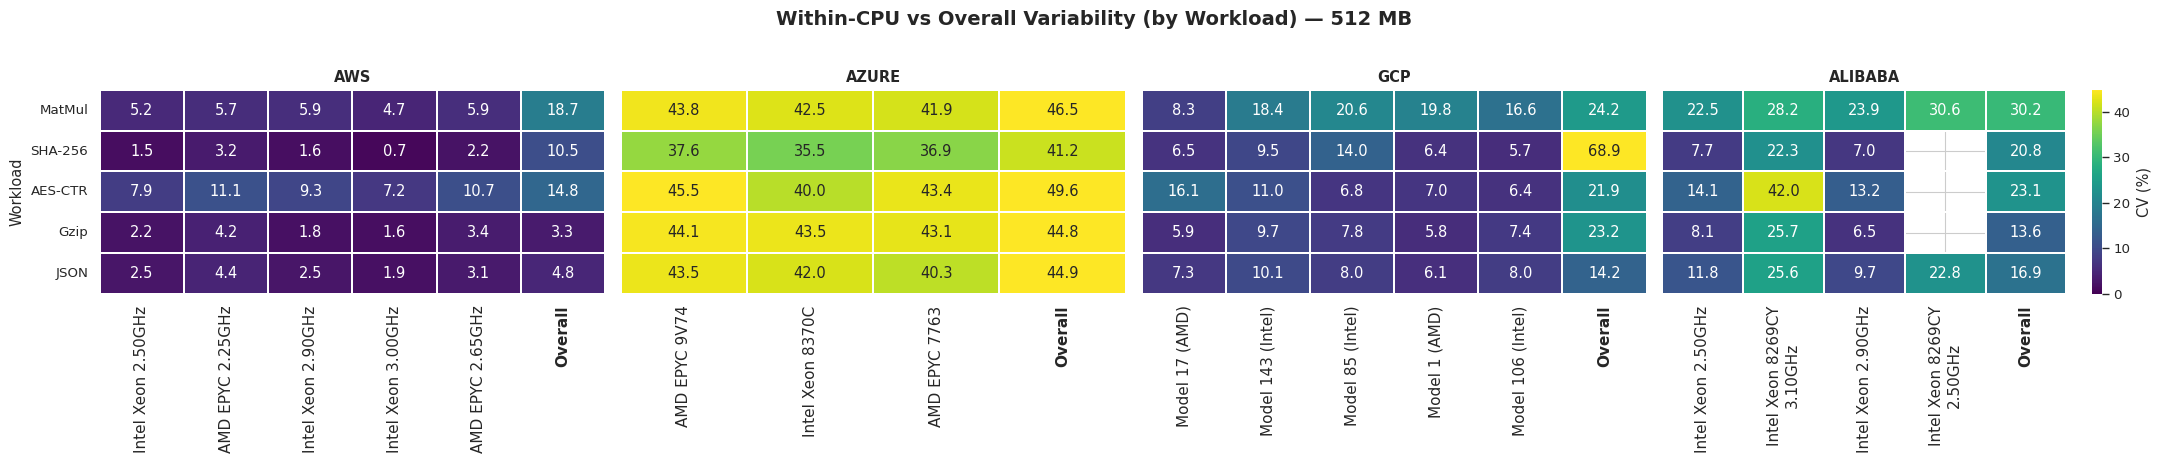

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.benchmark import metric_for_benchmark
import textwrap

sns.set_theme(style="whitegrid", context="paper", font_scale=1.1)



def plot_stage_c_cv_heatmap_by_workload(
    df: pd.DataFrame,
    memory_size: int = 512,
    providers: list[str] = None,
    workloads: list[str] = None,
    save_path: str | None = None,
    show: bool = True,
    gamma_for_vmax: float = 0.95,
    figsize: tuple = None,
) -> plt.Figure:
    providers = providers or ["aws", "azure", "gcp", "alibaba"]
    workloads = workloads or ["gemm", "sha256", "aesCtr", "gzip", "json"]

    # --- filter ---
    d0 = df.copy()
    d0["provider"] = d0["provider"].astype(str).str.lower()
    d0["benchmark_type"] = d0["benchmark_type"].astype(str)
    d0 = d0[
        (d0["memory_size_mb"] == memory_size)
        & (d0["provider"].isin(providers))
        & (d0["benchmark_type"].isin(workloads))
    ].copy()
    if d0.empty:
        raise ValueError("No rows left after filtering (memory/provider/workload).")

    # --- build long metric column (workload-specific metric col -> 'metric') ---
    parts = []
    for w in workloads:
        mcol = metric_for_benchmark(w)
        if mcol not in d0.columns:
            if "runtime_ms" not in d0.columns:
                raise ValueError(f"Missing metric column '{mcol}' and 'runtime_ms'.")
            mcol = "runtime_ms"

        sub = d0[d0["benchmark_type"] == w][["provider", "benchmark_type", "cpu_type", mcol]].copy()
        sub["metric"] = pd.to_numeric(sub[mcol], errors="coerce")
        parts.append(sub[["provider", "benchmark_type", "cpu_type", "metric"]])

    d = pd.concat(parts, ignore_index=True).dropna(subset=["cpu_type", "metric"])

    # --- CV stats ---
    cpu_stats = d.groupby(["provider", "benchmark_type", "cpu_type"])["metric"].agg(["mean", "std"]).reset_index()
    cpu_stats["cv"] = (cpu_stats["std"] / cpu_stats["mean"]) * 100.0

    overall_stats = d.groupby(["provider", "benchmark_type"])["metric"].agg(["mean", "std"]).reset_index()
    overall_stats["cv"] = (overall_stats["std"] / overall_stats["mean"]) * 100.0

    cpu_stats["cv"] = cpu_stats["cv"].replace([np.inf, -np.inf], np.nan)
    overall_stats["cv"] = overall_stats["cv"].replace([np.inf, -np.inf], np.nan)

    all_cv = pd.concat([cpu_stats["cv"], overall_stats["cv"]], ignore_index=True)
    all_cv = all_cv[np.isfinite(all_cv.to_numpy())]
    vmax = float(np.nanpercentile(all_cv, gamma_for_vmax * 100.0)) if len(all_cv) else 1.0
    vmax = max(vmax, 1.0)

    vmin = 0.0
    if figsize is None:
        figsize = (5.5 * len(providers), 4.5)

    # --- plot ---
    fig, axes = plt.subplots(1, len(providers), figsize=figsize, sharey=True)
    if len(providers) == 1:
        axes = [axes]

    for i, prov in enumerate(providers):
        ax = axes[i]

        sub_cpu = cpu_stats[cpu_stats["provider"] == prov]
        sub_overall = overall_stats[overall_stats["provider"] == prov]

        pivot = (
            sub_cpu.pivot_table(index="benchmark_type", columns="cpu_type", values="cv", aggfunc="mean")
            .reindex(index=workloads)
        )

        pivot.index = [BENCHMARK_LABEL.get(w, w) for w in workloads]

        overall_series = sub_overall.set_index("benchmark_type")["cv"].reindex(workloads).to_numpy()
        pivot["Overall"] = overall_series

        cpu_order = d[d["provider"] == prov]["cpu_type"].value_counts().index.tolist()
        cols = [c for c in cpu_order if c in pivot.columns] + ["Overall"]
        pivot = pivot[cols]


        sns.heatmap(
            pivot,
            ax=ax,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=".1f",
            linewidths=0.3,
            linecolor="white",
            cbar=(i == len(providers) - 1),
            cbar_kws={"label": "CV (%)"},
        )

        wrap = lambda s: "\n".join(textwrap.wrap(s, width=20))

        wrap = lambda s: "\n".join(textwrap.wrap(str(s), width=20))
        ax.set_xticklabels(
            ["Overall" if c == "Overall" else wrap(c) for c in pivot.columns],
            rotation=90,
            ha="center",
        )


        for t in ax.get_xticklabels():
            if t.get_text() == "Overall":
                t.set_fontweight("bold")

        ax.set_title(prov.upper(), fontweight="bold")
        ax.set_ylabel("Workload" if i == 0 else "")
        ax.set_xlabel("")
        ax.tick_params(axis="x", rotation=90, labelsize=11)
        ax.tick_params(axis="y", rotation=0)

    fig.suptitle(
        f"Within-CPU vs Overall Variability (by Workload) — {memory_size} MB",
        fontsize=14, fontweight="bold", y=1.02
    )

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"Saved: {save_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig


# Example
fig = plot_stage_c_cv_heatmap_by_workload(
    df,
    memory_size=512,
    providers=["aws", "azure", "gcp", "alibaba"],
    workloads=["gemm", "sha256", "aesCtr", "gzip", "json"],
    save_path="plots/stage_c/within_cpu_vs_overall_cv_by_workload_512mb.pdf",
)


Saved: plots/stage_c/temporal_dynamics/aws/trend_gemm_aws_512mb.pdf


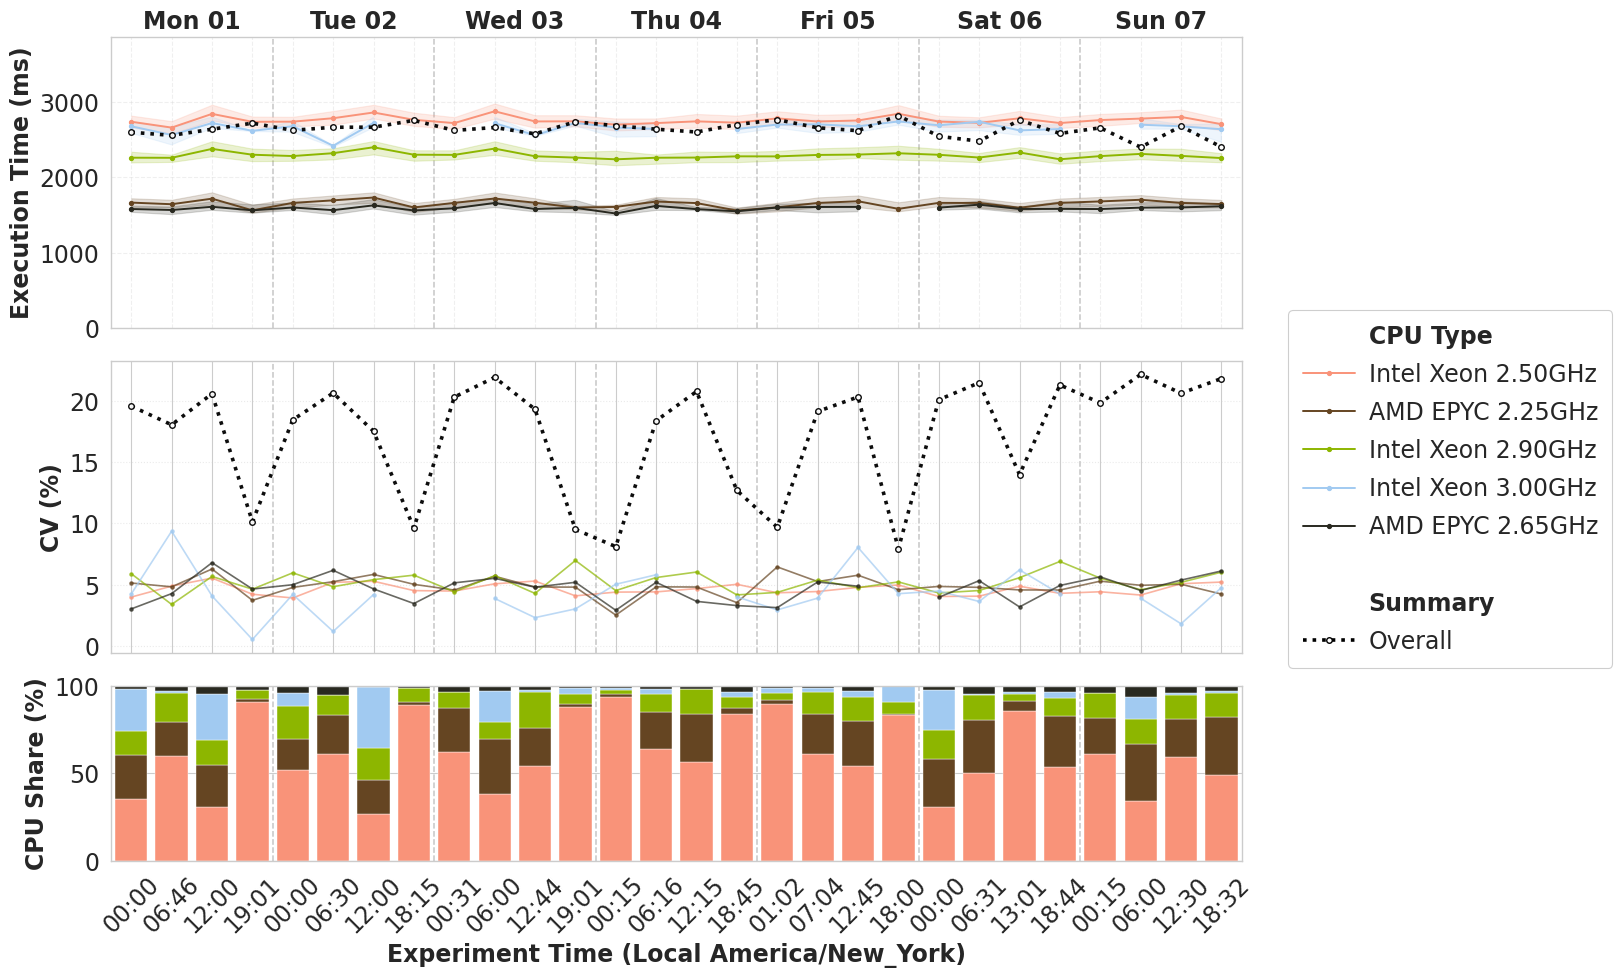

Saved: plots/stage_c/temporal_dynamics/aws/trend_sha256_aws_512mb.pdf


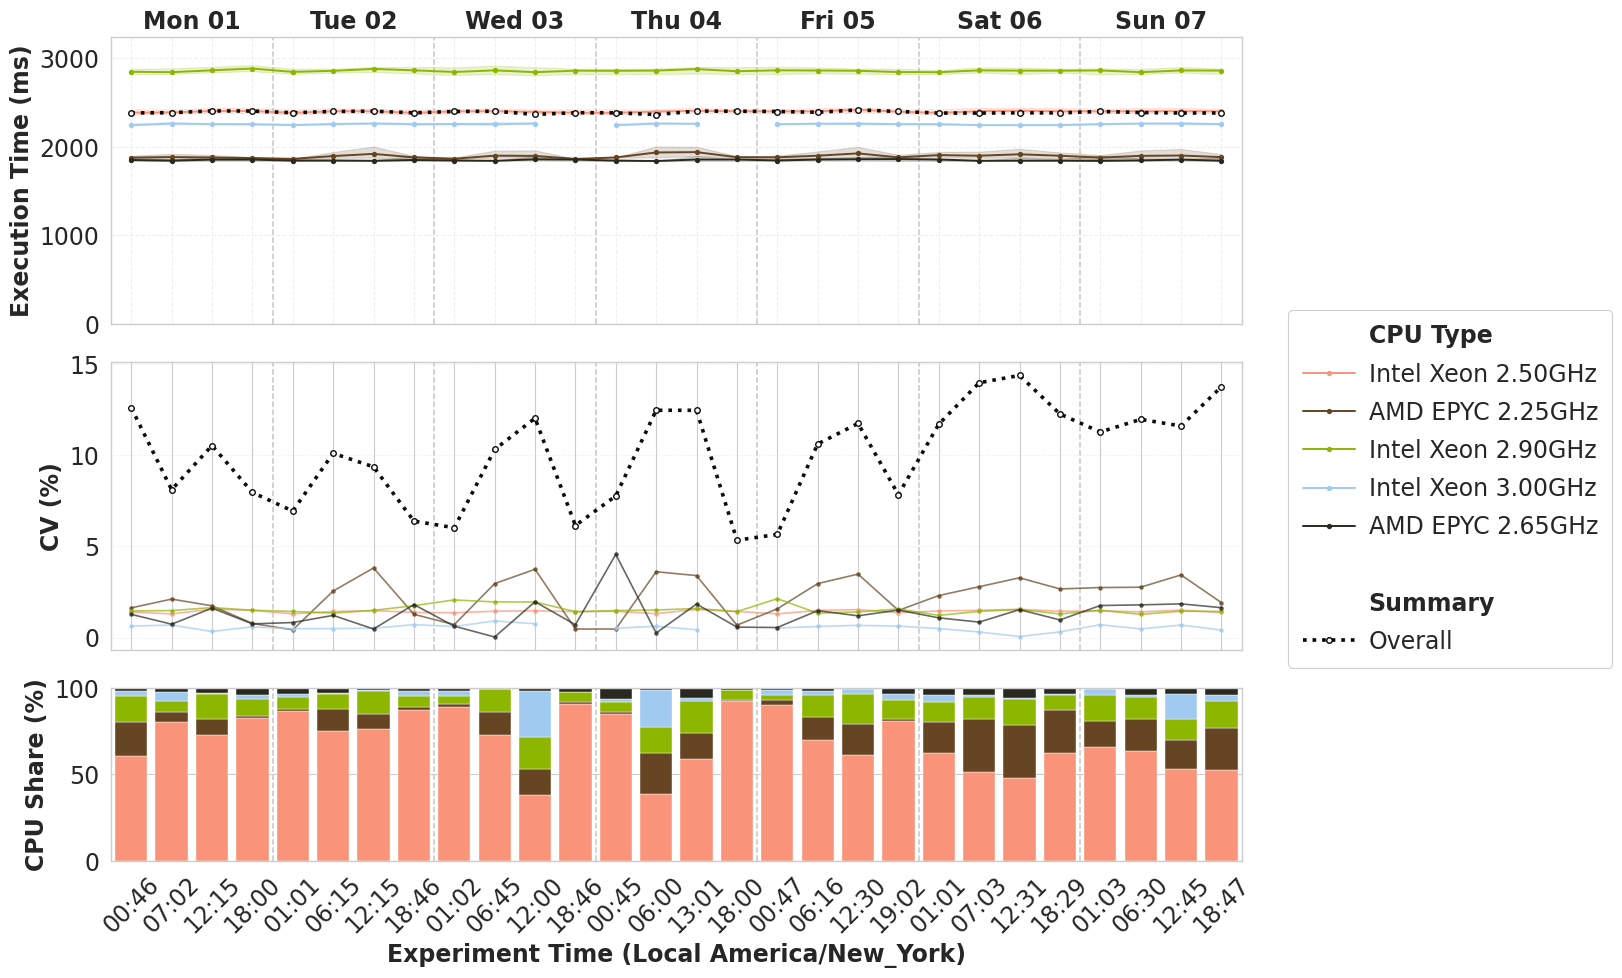

Saved: plots/stage_c/temporal_dynamics/aws/trend_gzip_aws_512mb.pdf


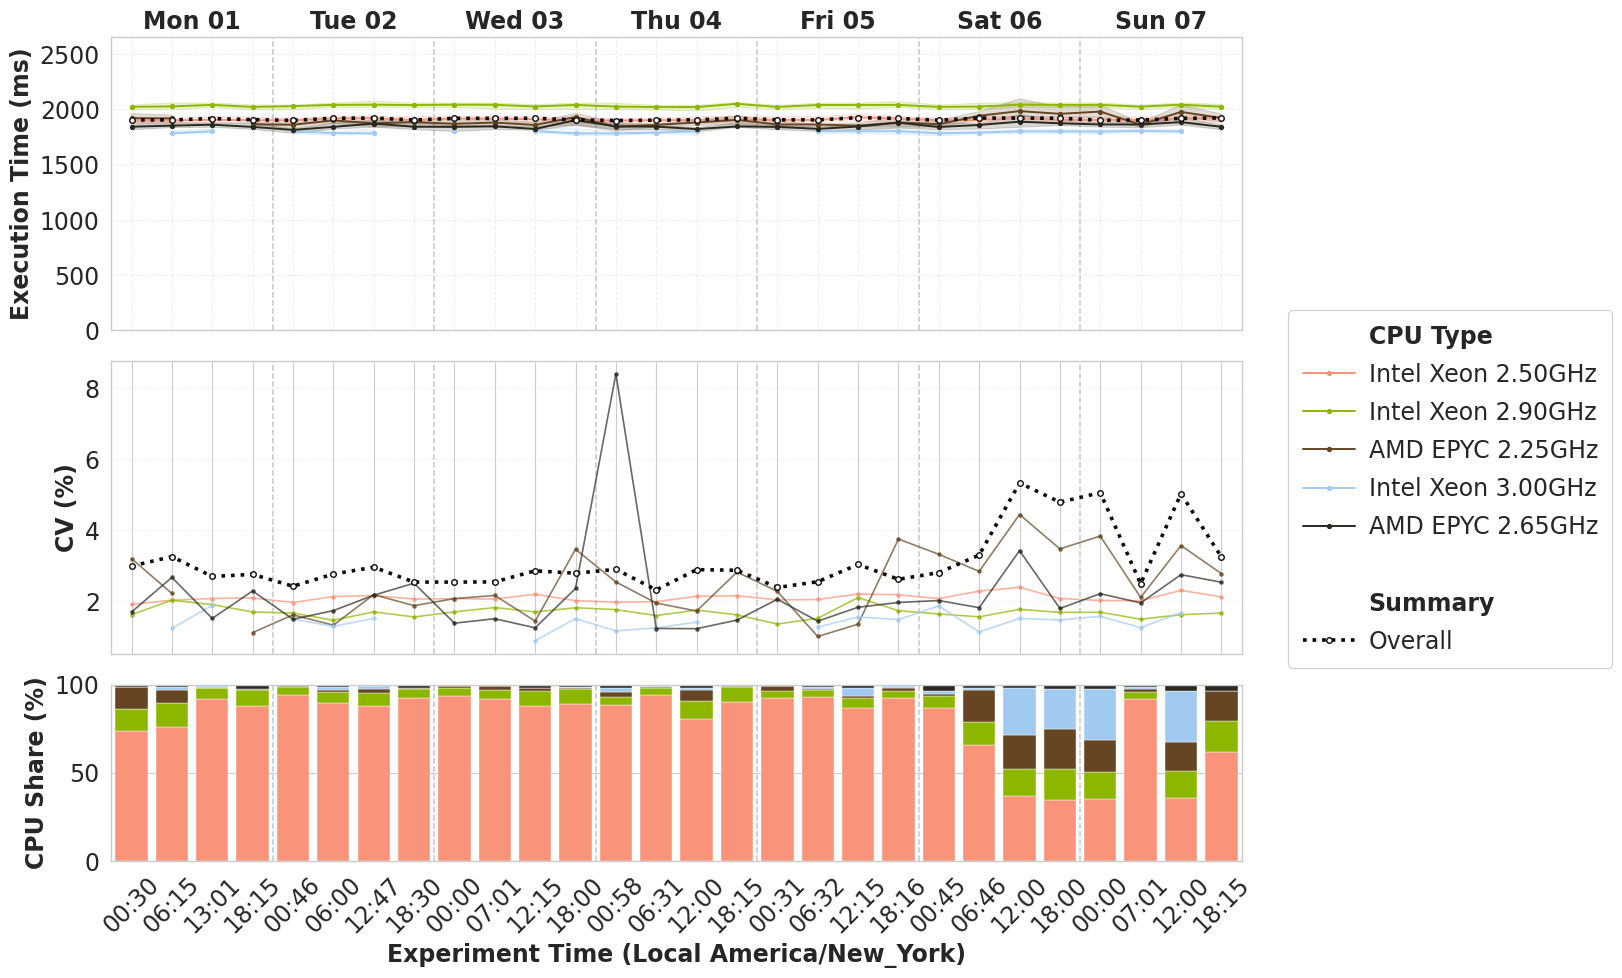

Saved: plots/stage_c/temporal_dynamics/aws/trend_aesCtr_aws_512mb.pdf


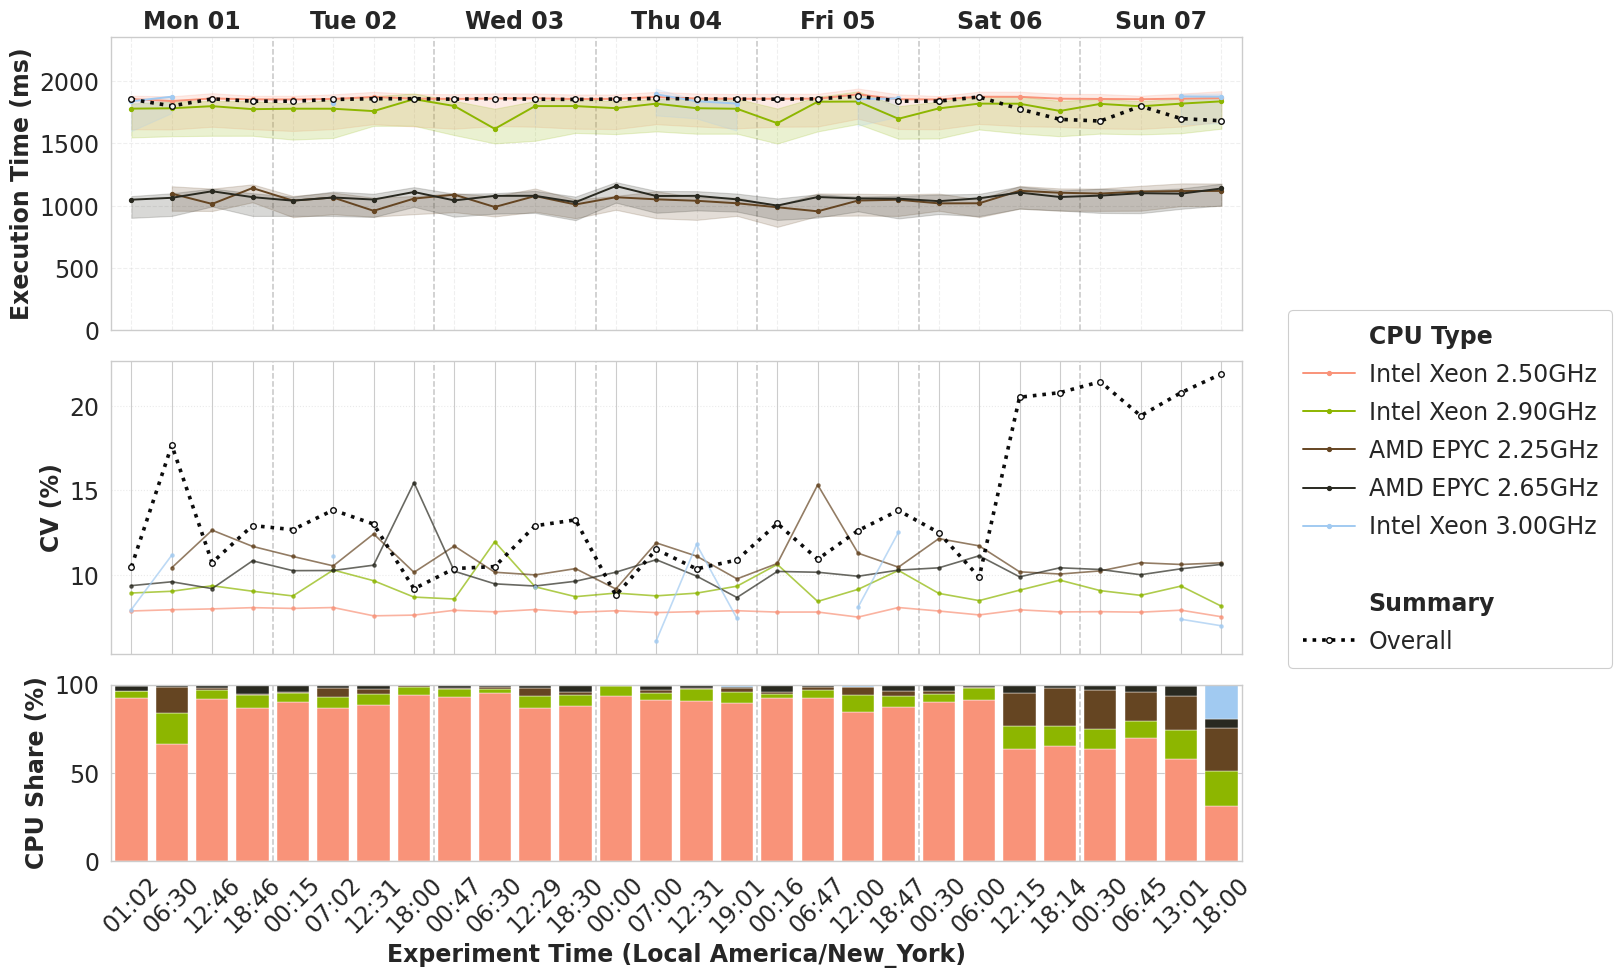

Saved: plots/stage_c/temporal_dynamics/aws/trend_json_aws_512mb.pdf


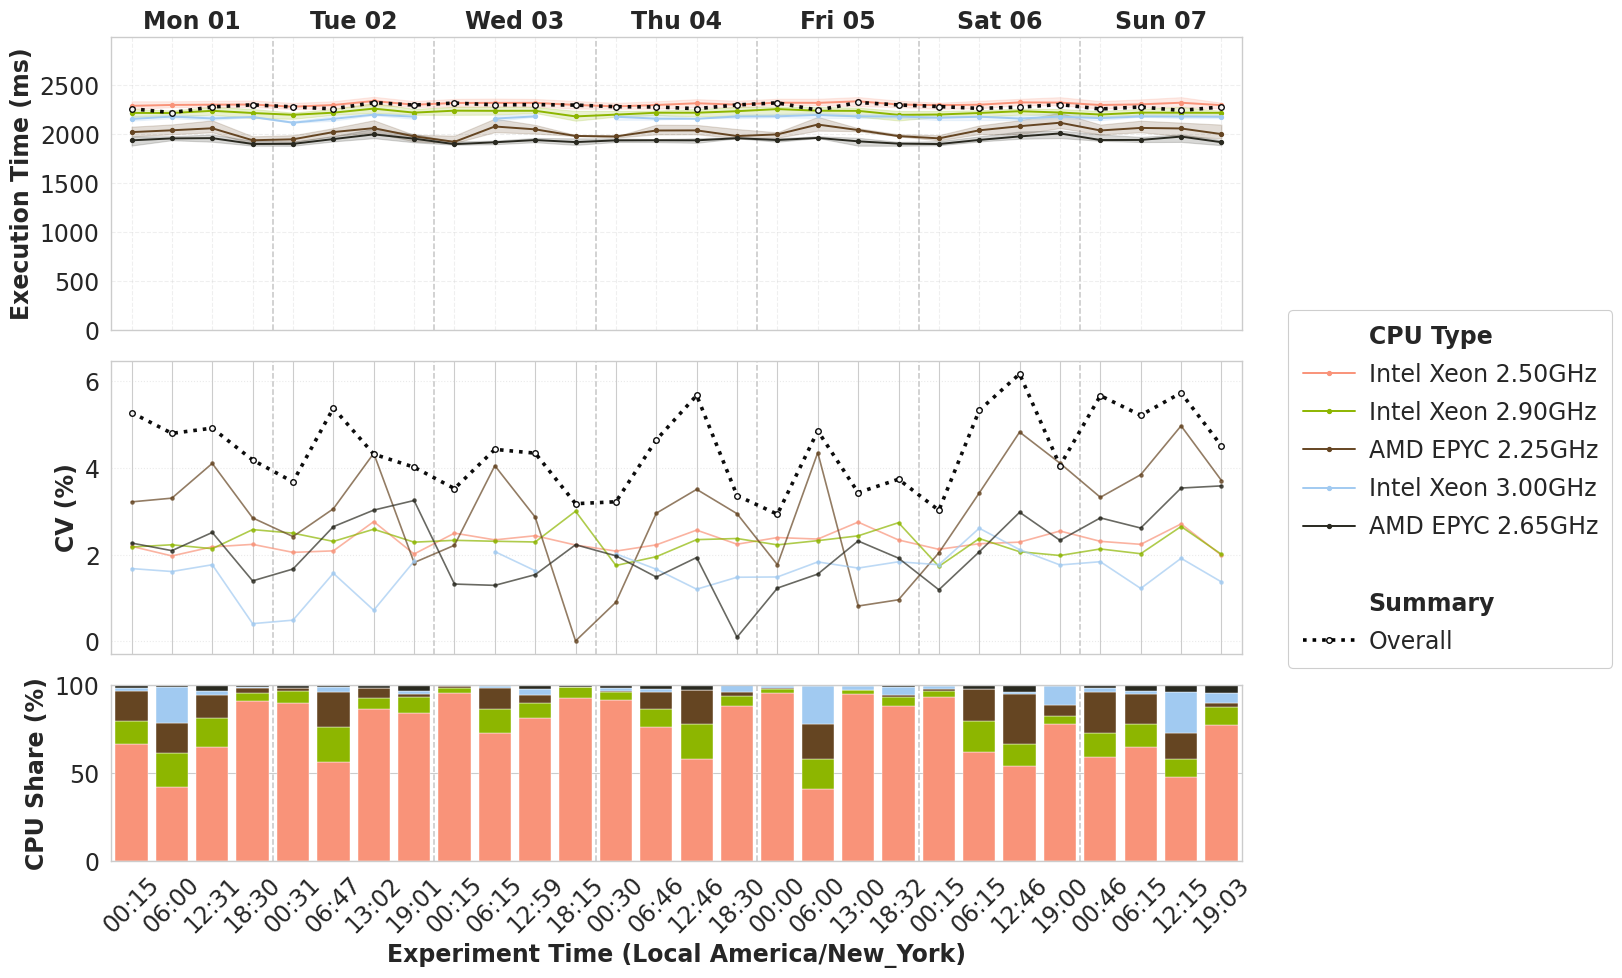

Saved: plots/stage_c/temporal_dynamics/gcp/trend_gemm_gcp_512mb.pdf


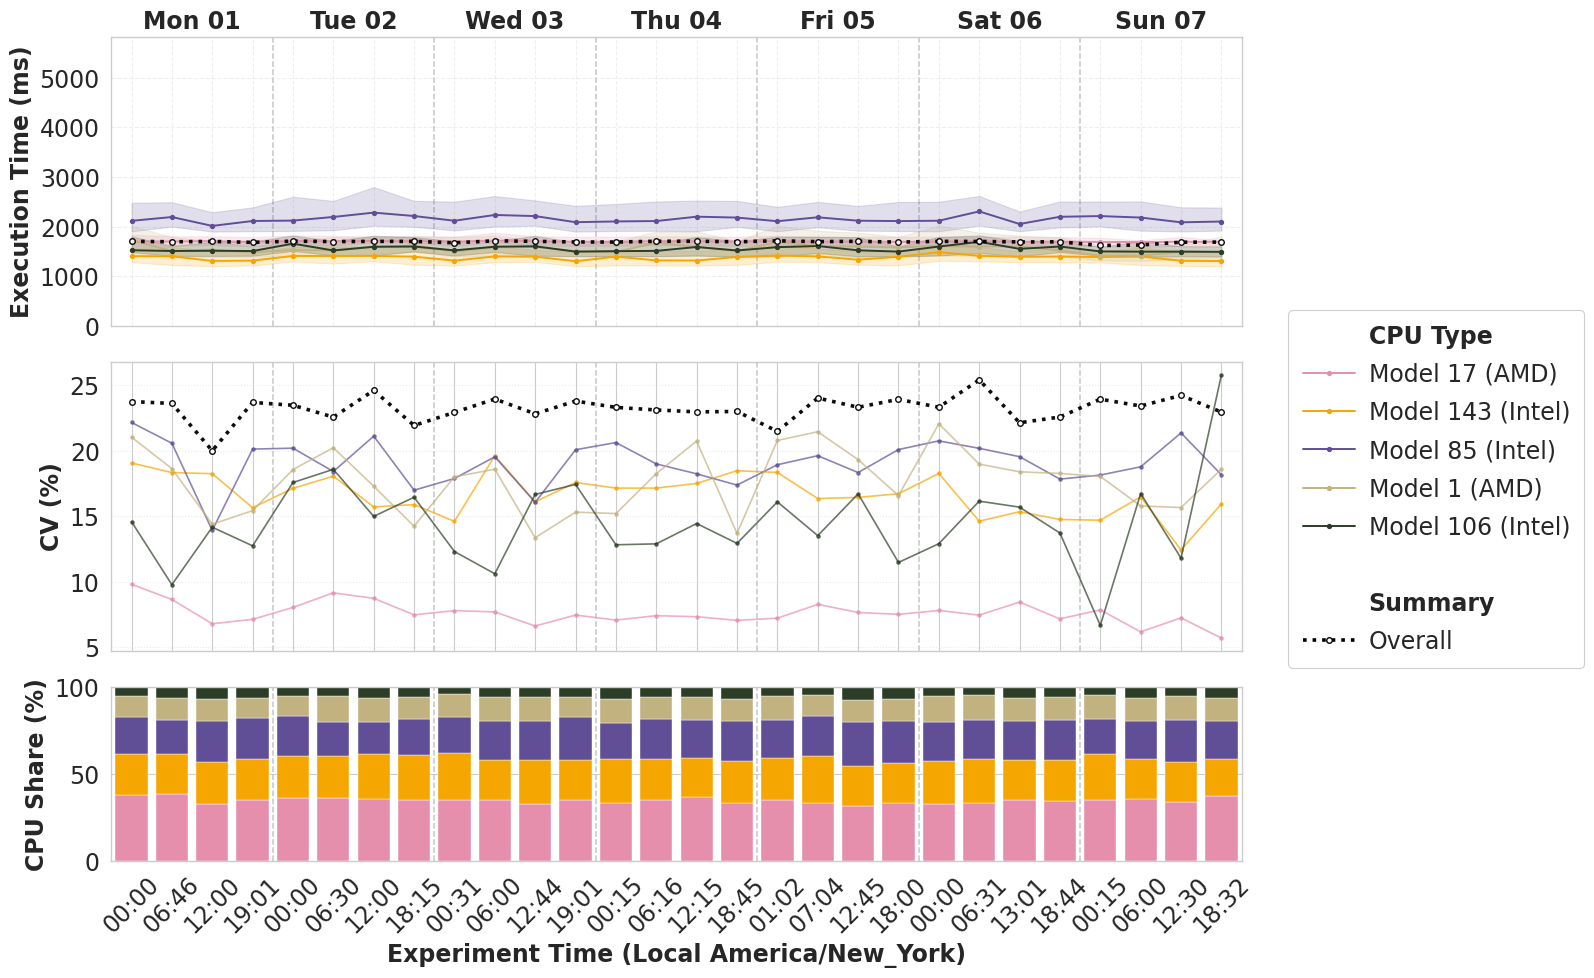

Saved: plots/stage_c/temporal_dynamics/gcp/trend_sha256_gcp_512mb.pdf


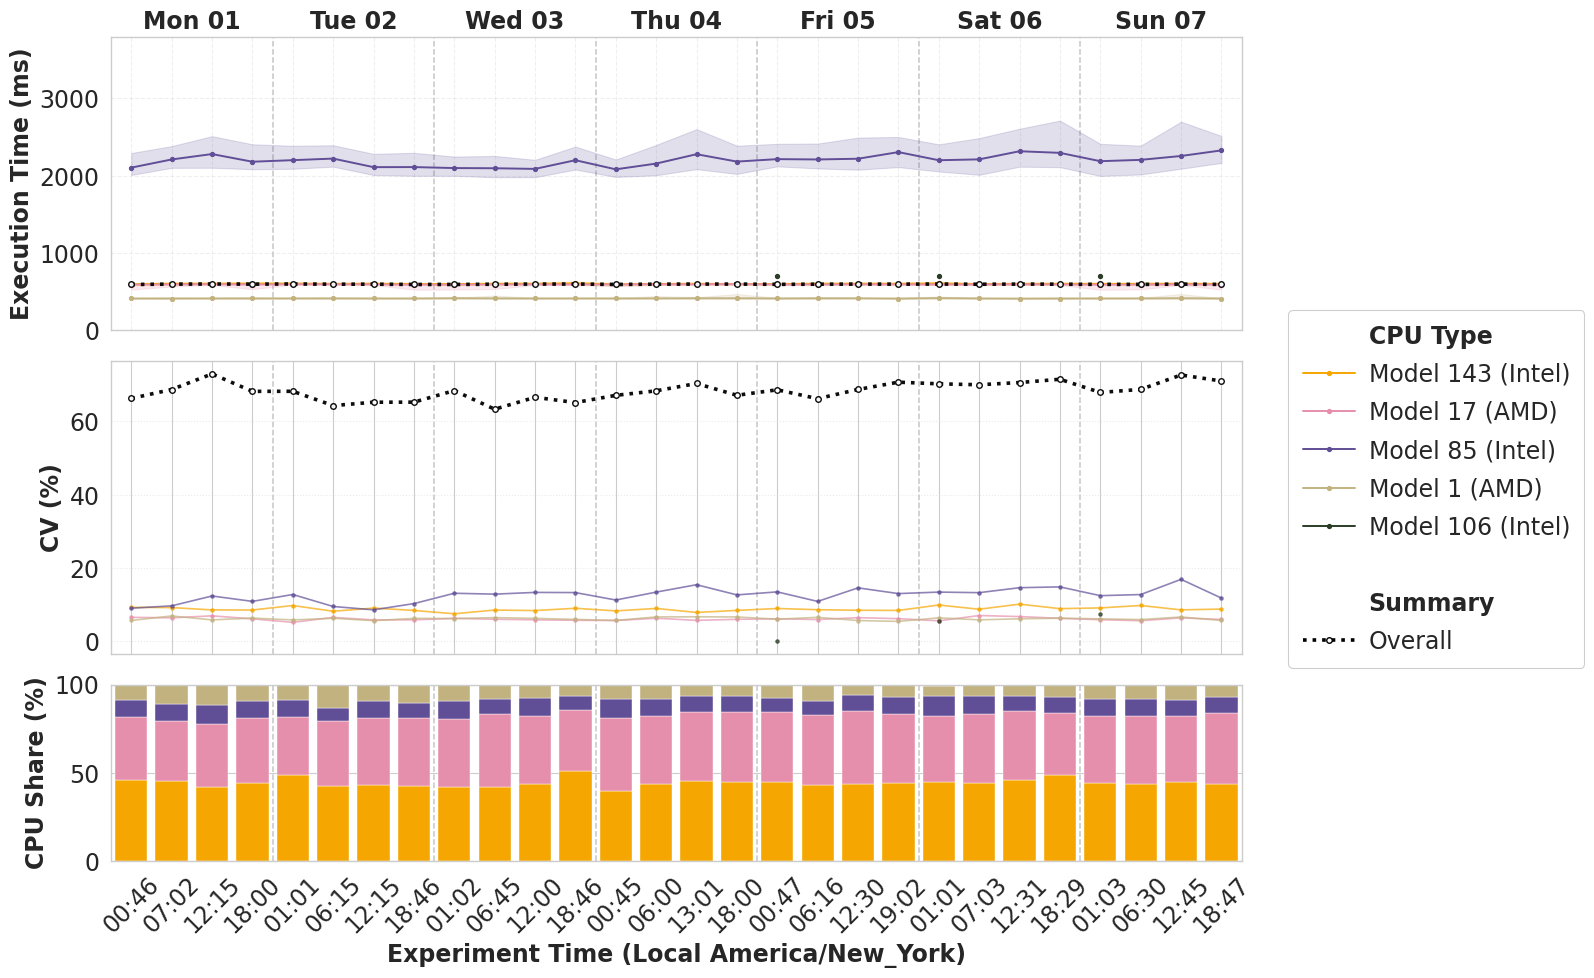

Saved: plots/stage_c/temporal_dynamics/gcp/trend_gzip_gcp_512mb.pdf


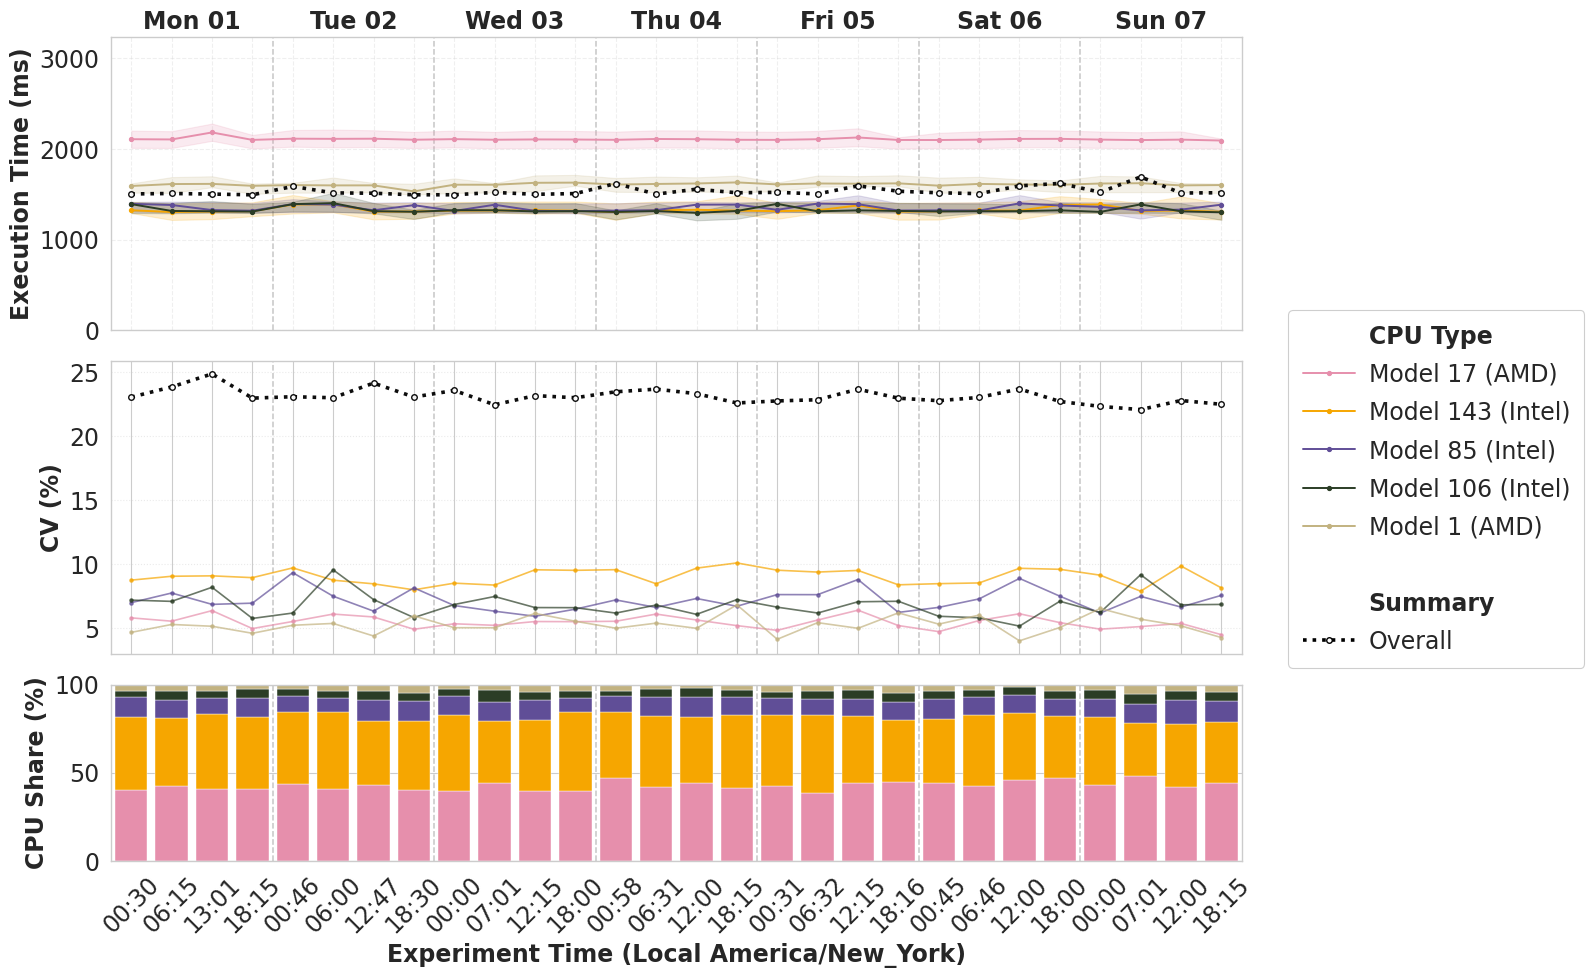

Saved: plots/stage_c/temporal_dynamics/gcp/trend_aesCtr_gcp_512mb.pdf


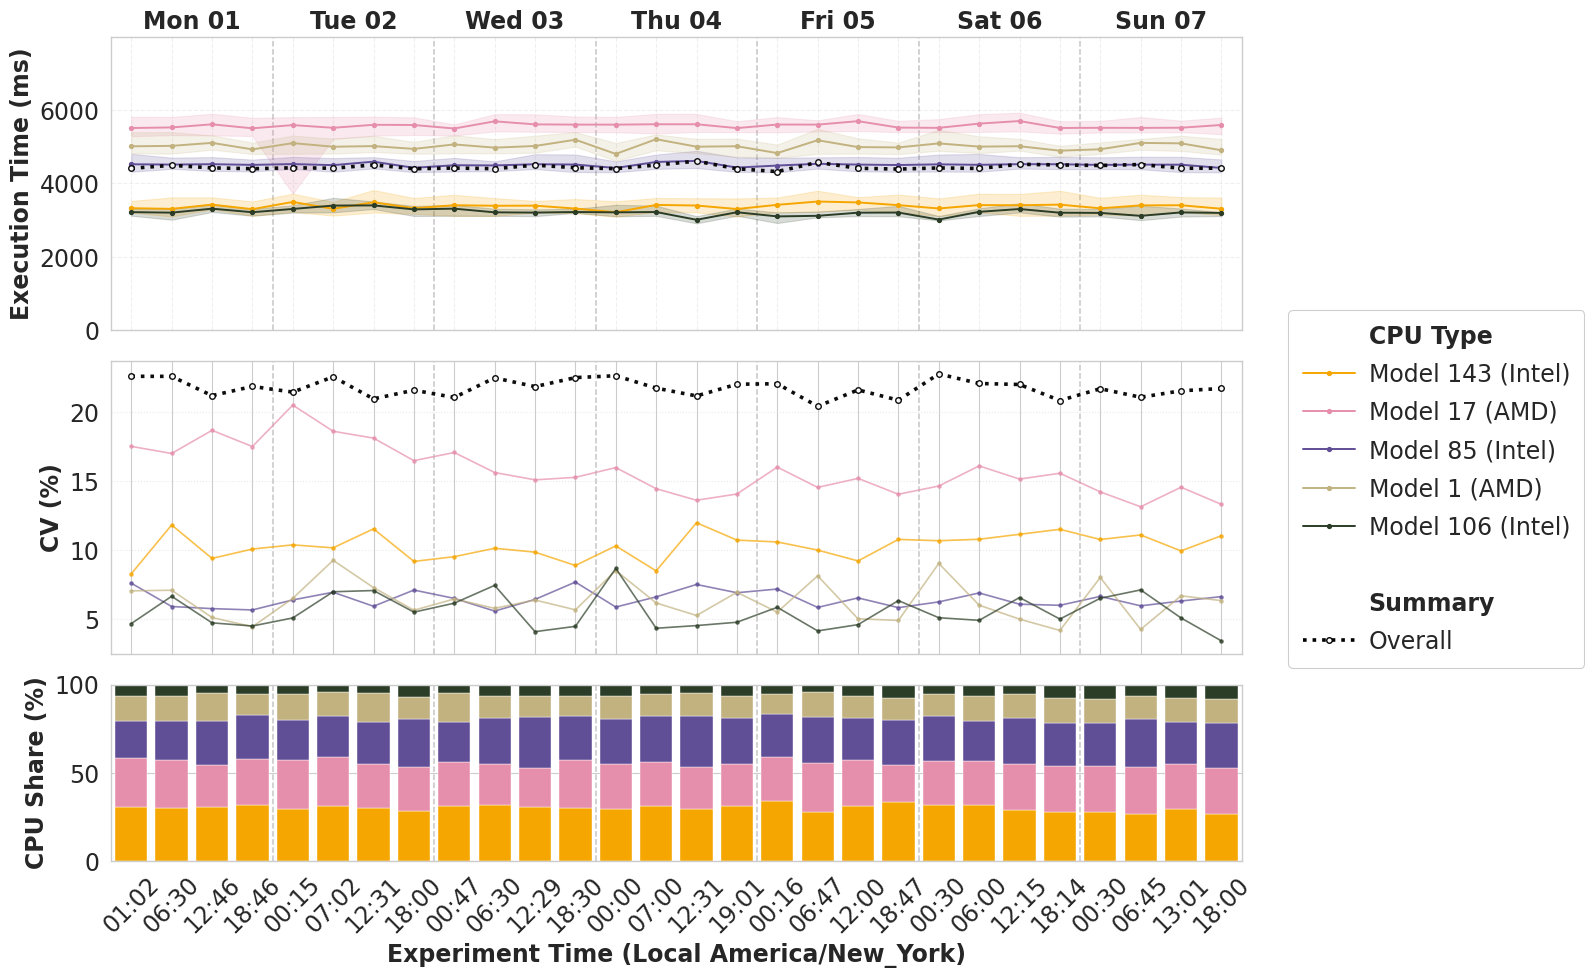

Saved: plots/stage_c/temporal_dynamics/gcp/trend_json_gcp_512mb.pdf


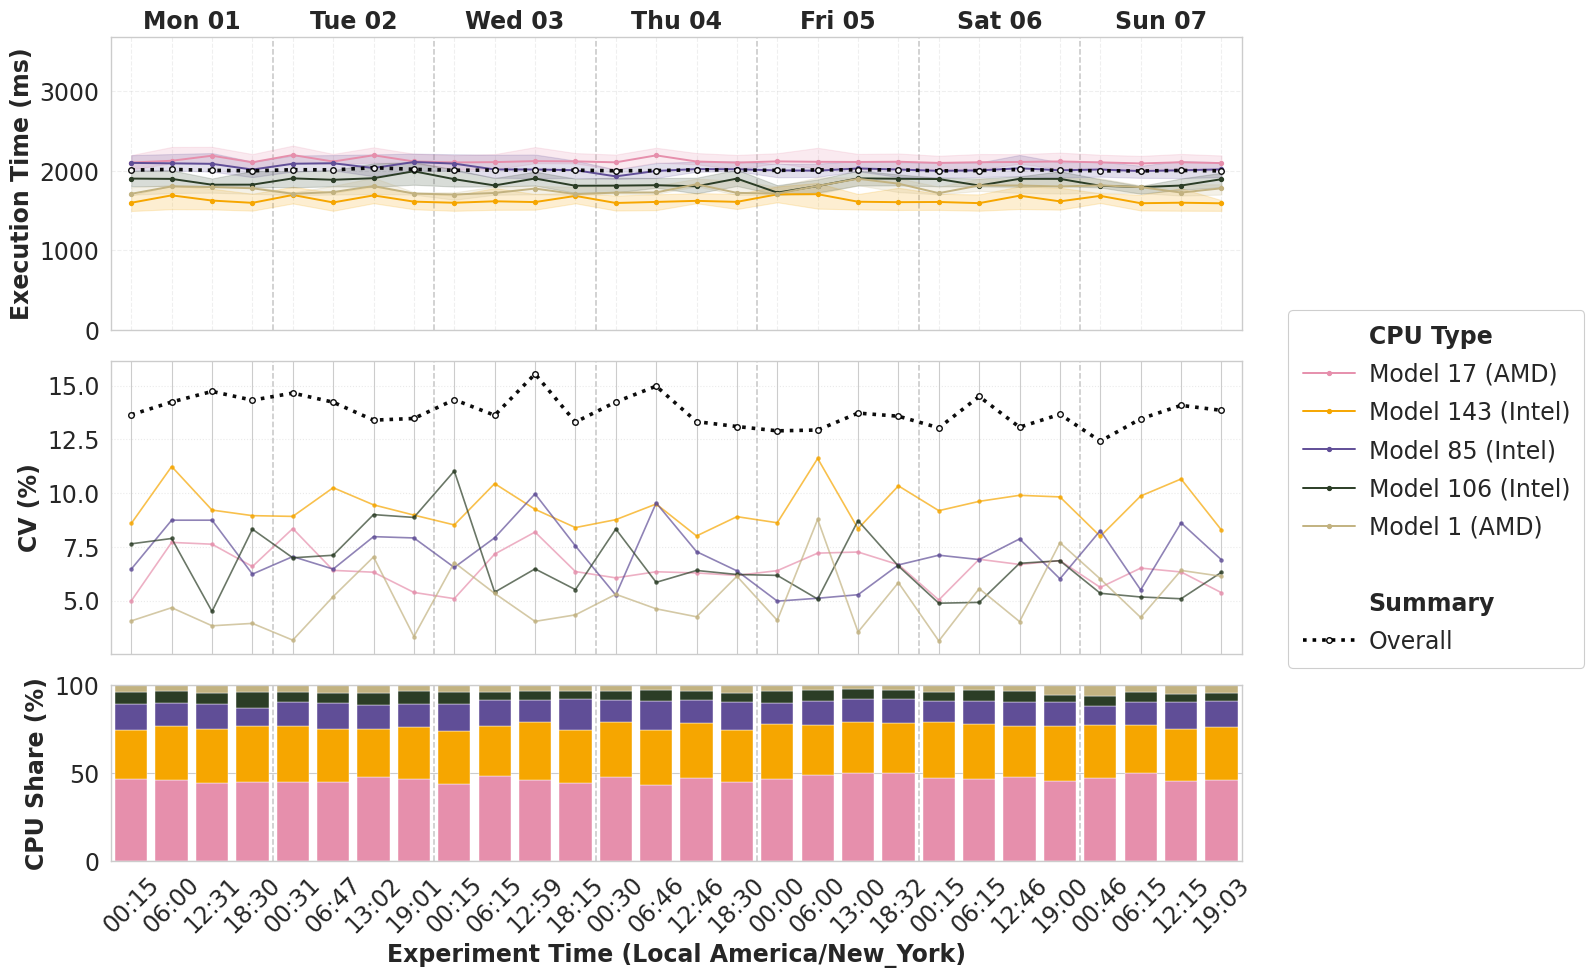

Saved: plots/stage_c/temporal_dynamics/alibaba/trend_gemm_alibaba_512mb.pdf


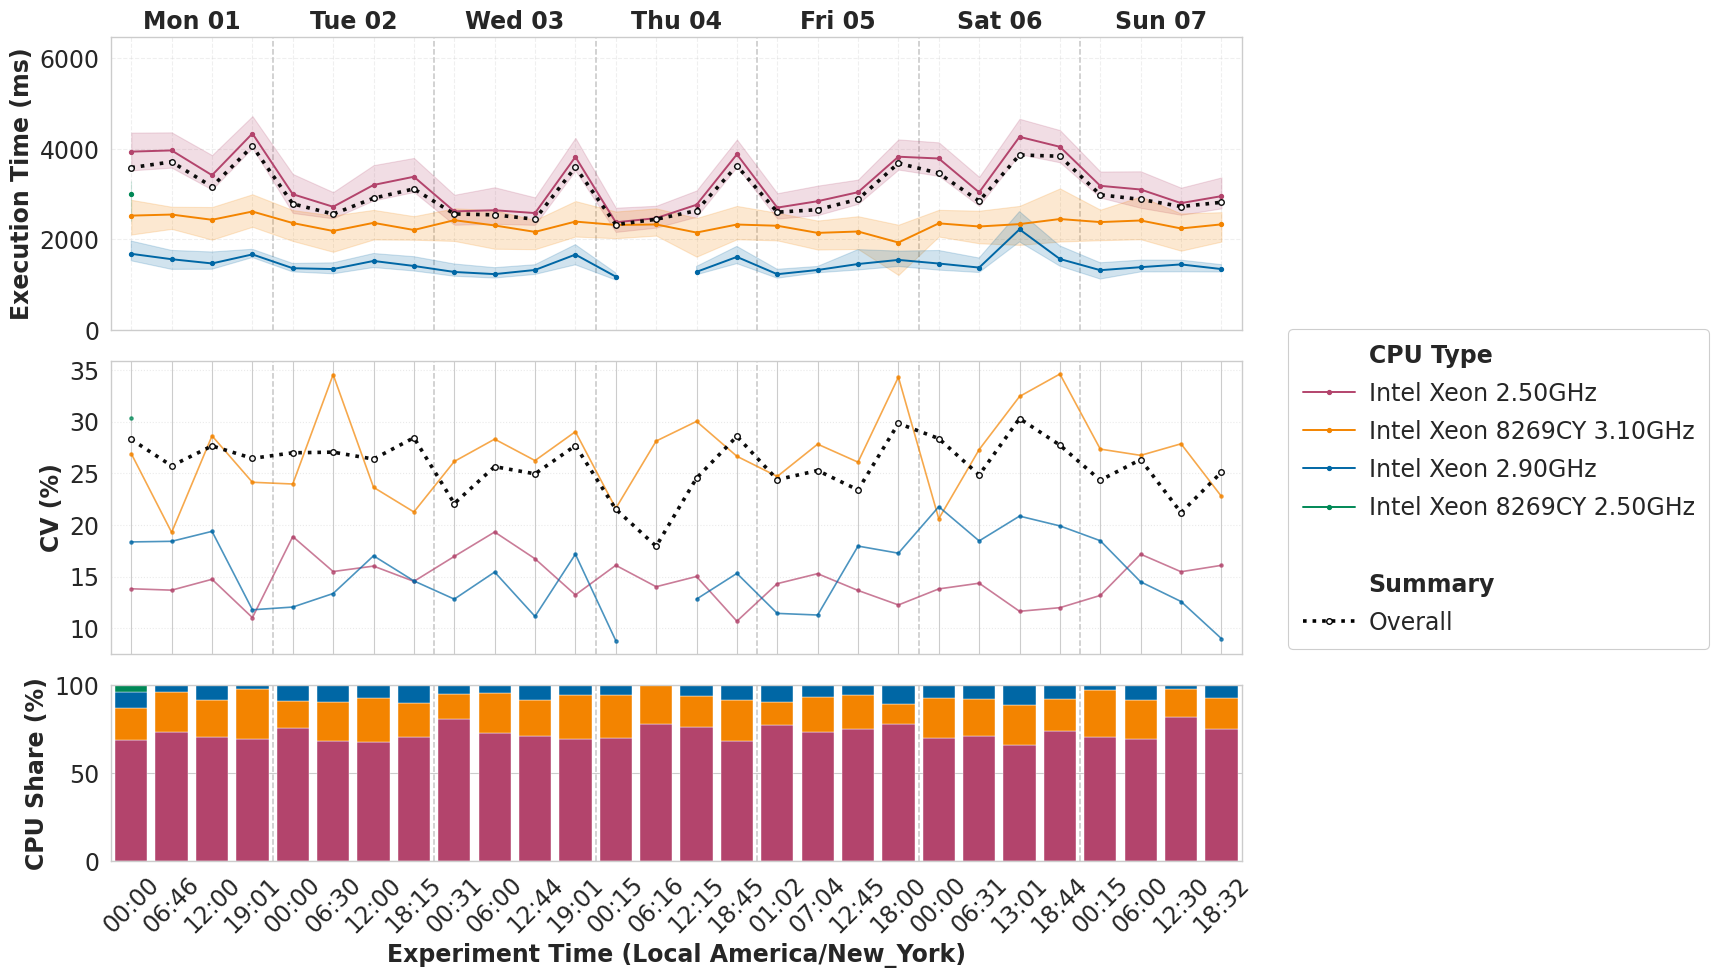

Saved: plots/stage_c/temporal_dynamics/alibaba/trend_sha256_alibaba_512mb.pdf


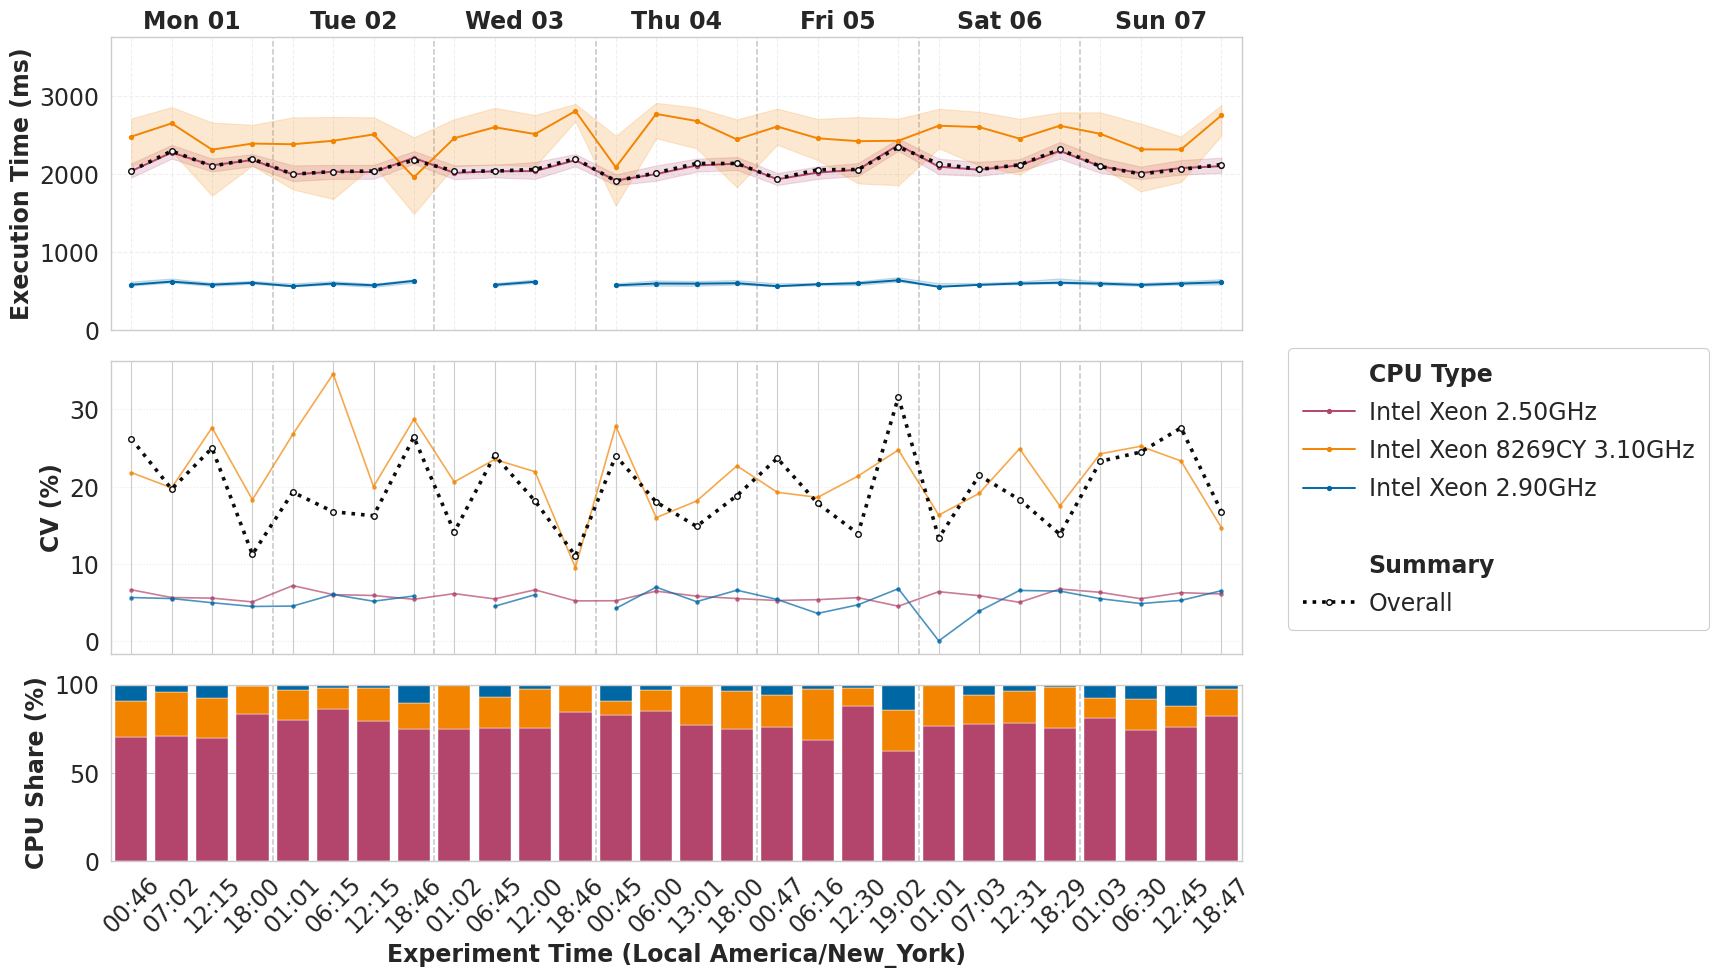

Saved: plots/stage_c/temporal_dynamics/alibaba/trend_gzip_alibaba_512mb.pdf


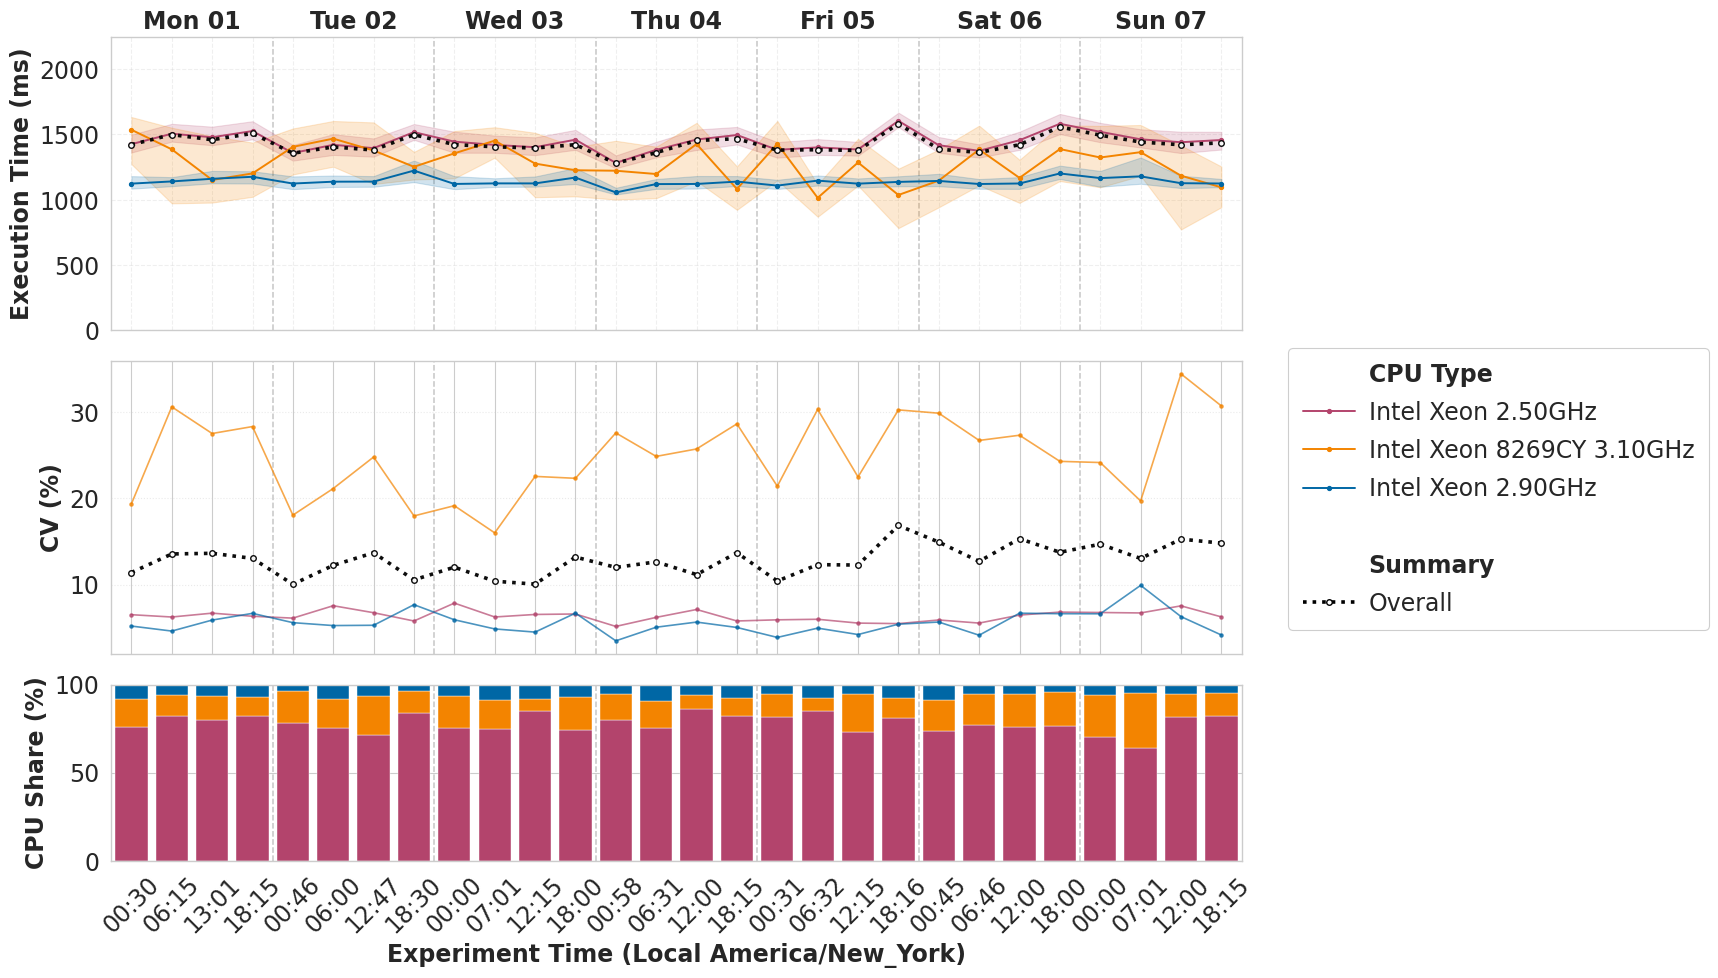

Saved: plots/stage_c/temporal_dynamics/alibaba/trend_aesCtr_alibaba_512mb.pdf


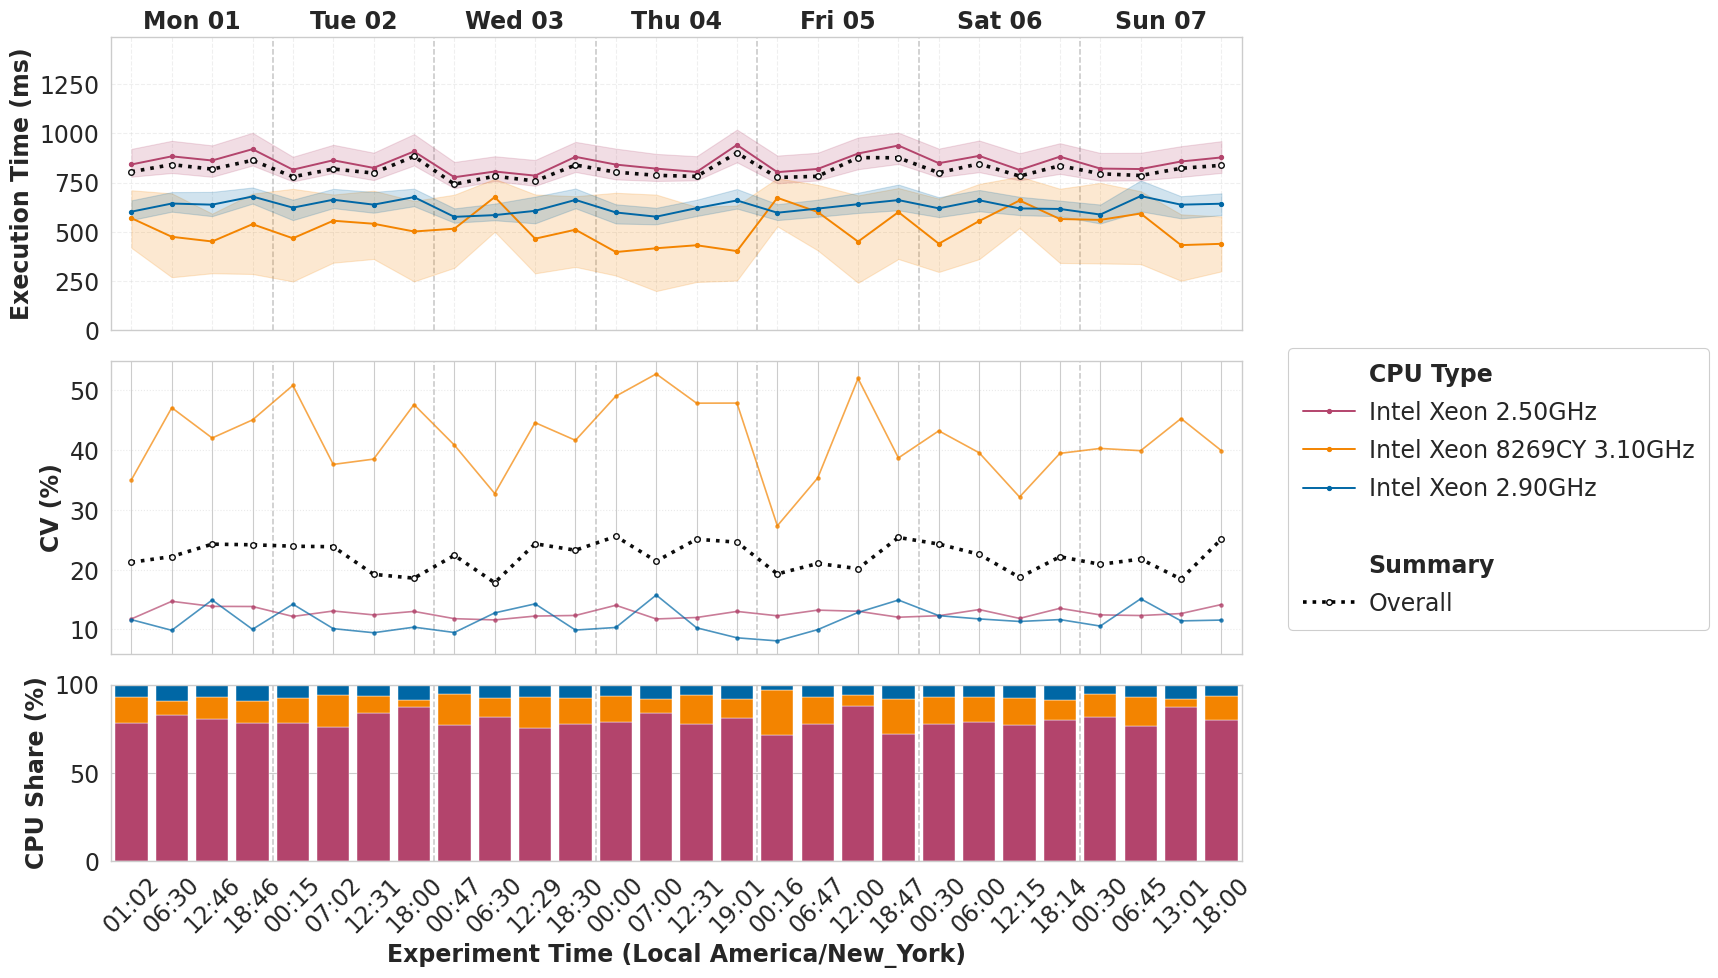

Saved: plots/stage_c/temporal_dynamics/alibaba/trend_json_alibaba_512mb.pdf


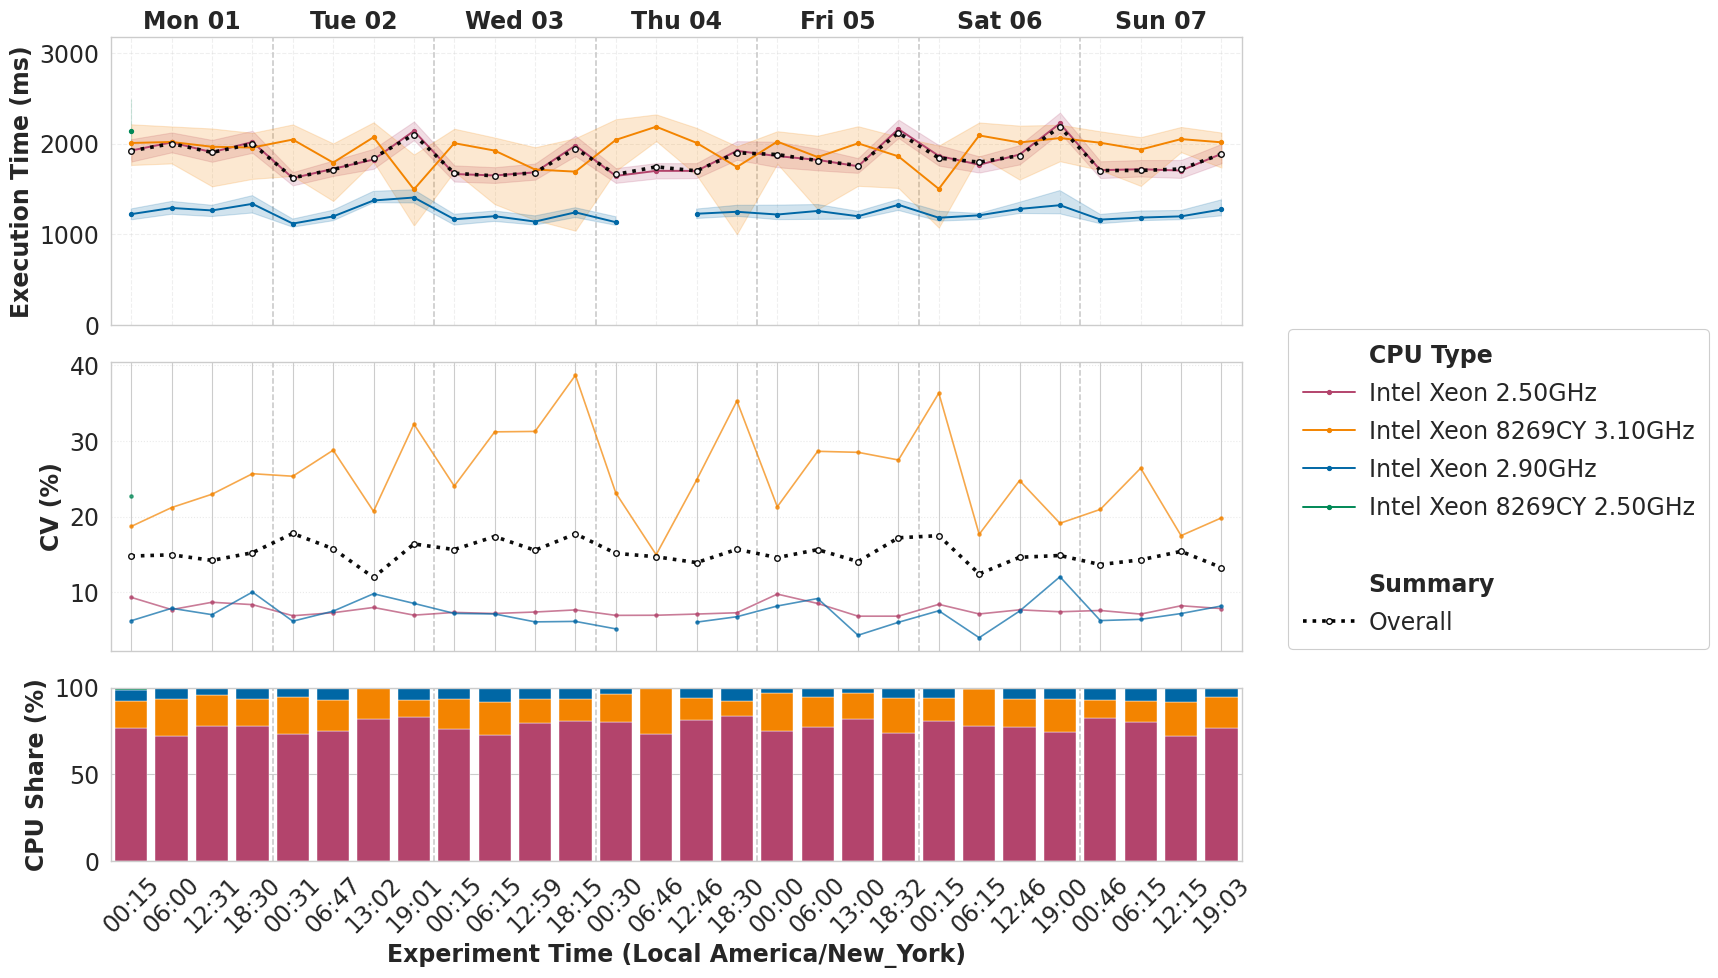

Saved: plots/stage_c/temporal_dynamics/azure/trend_gemm_azure_512mb.pdf


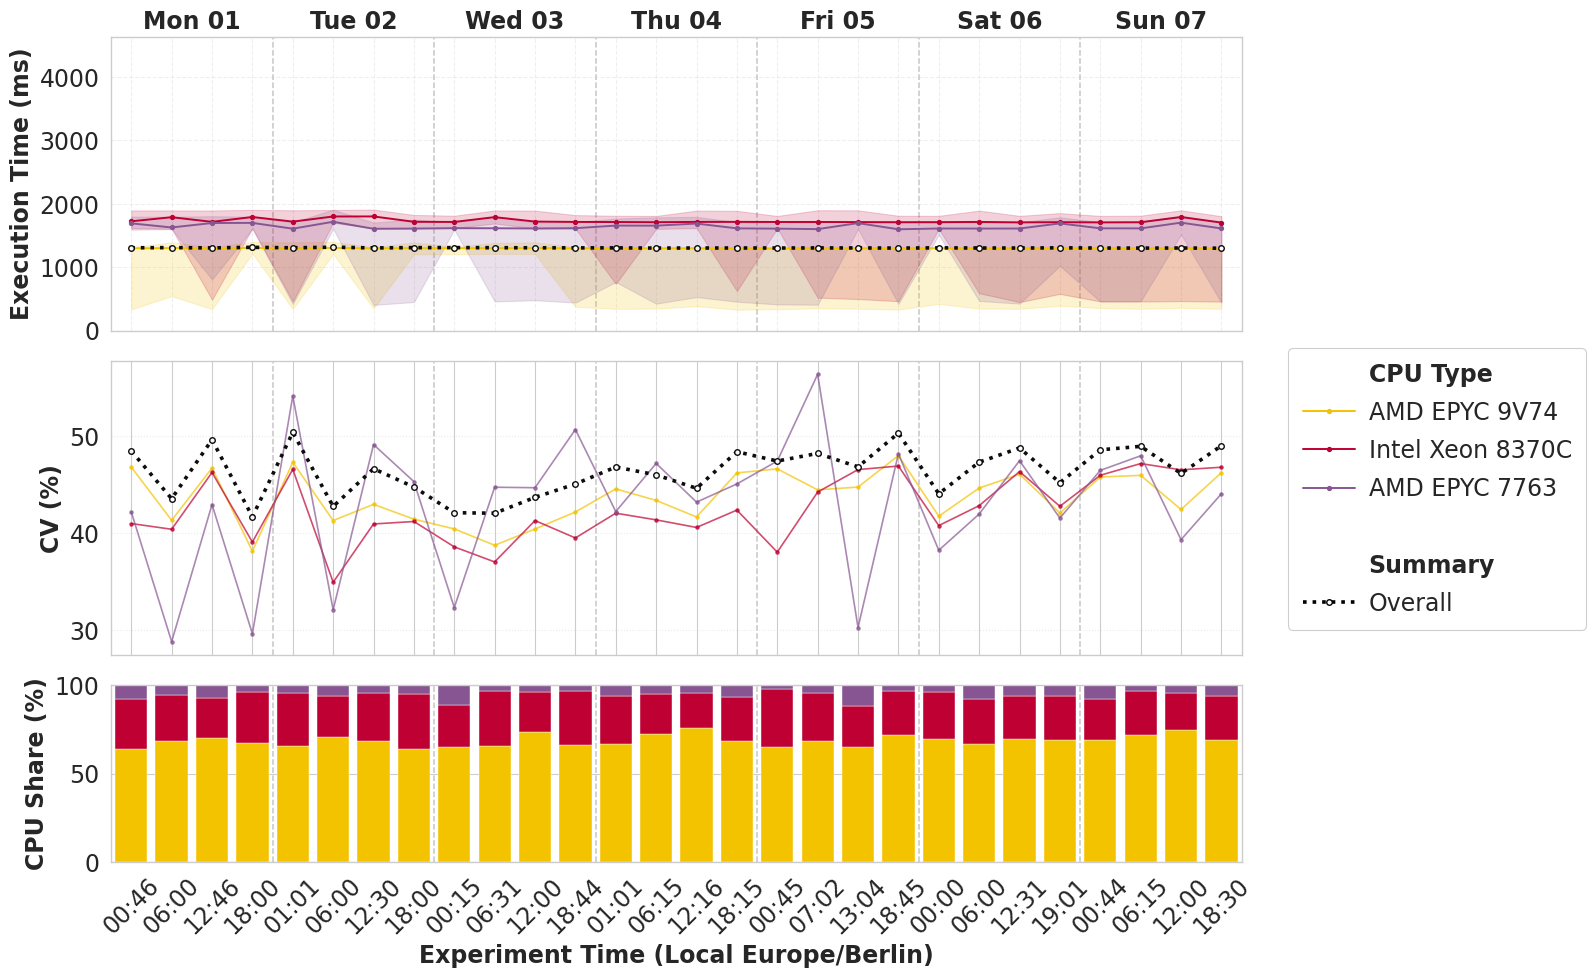

Saved: plots/stage_c/temporal_dynamics/azure/trend_sha256_azure_512mb.pdf


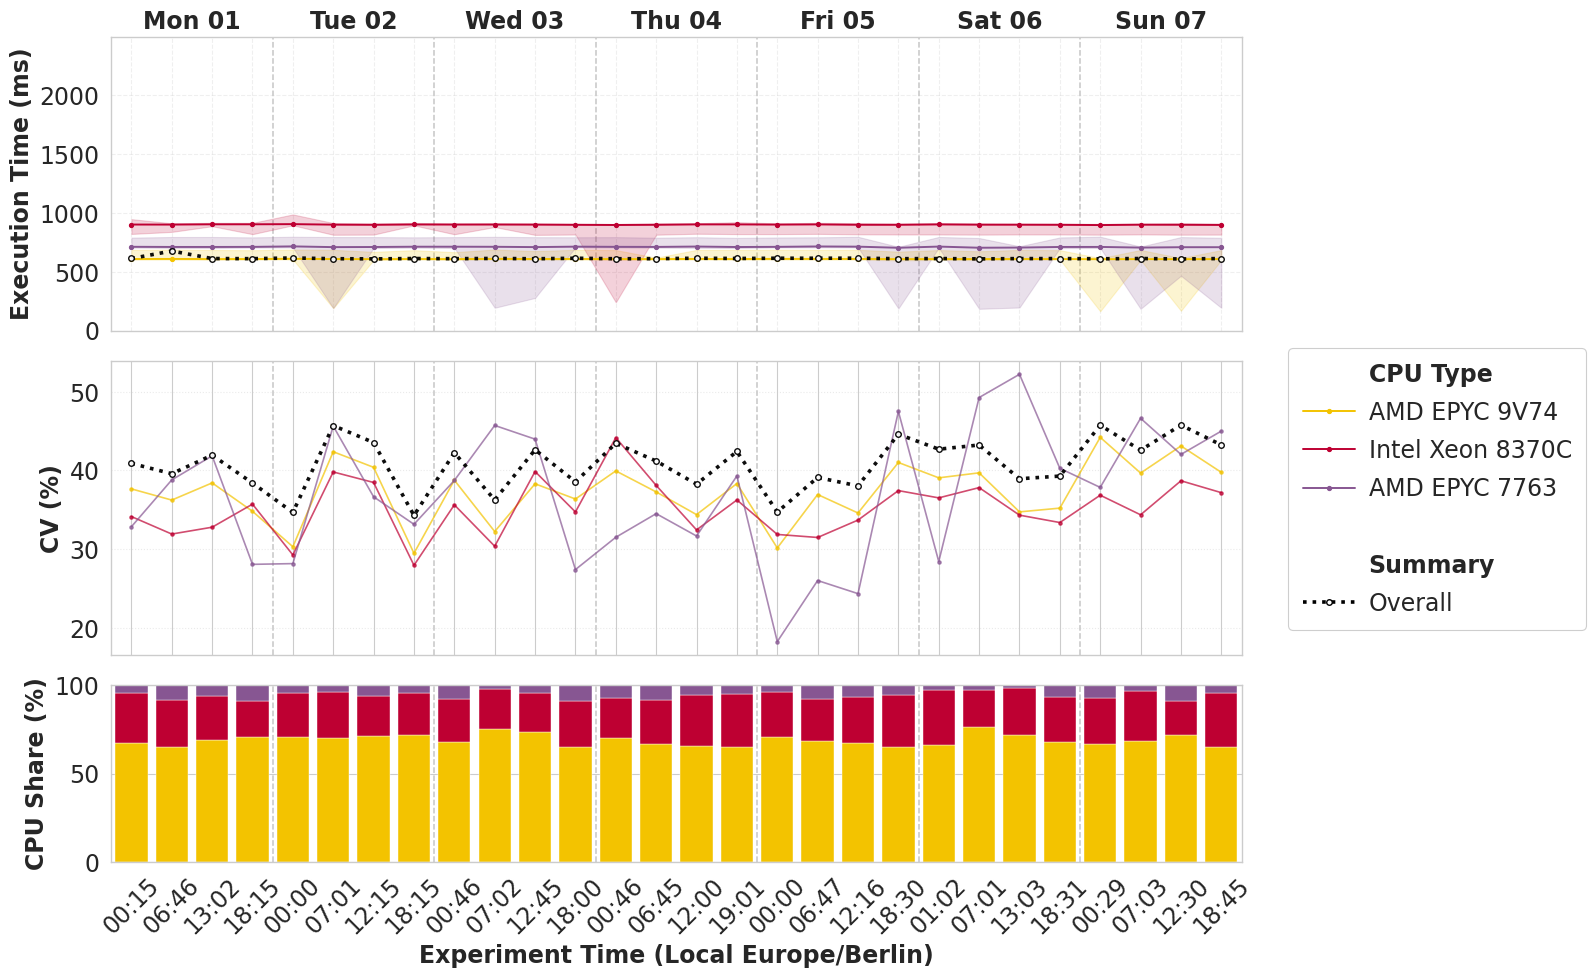

Saved: plots/stage_c/temporal_dynamics/azure/trend_gzip_azure_512mb.pdf


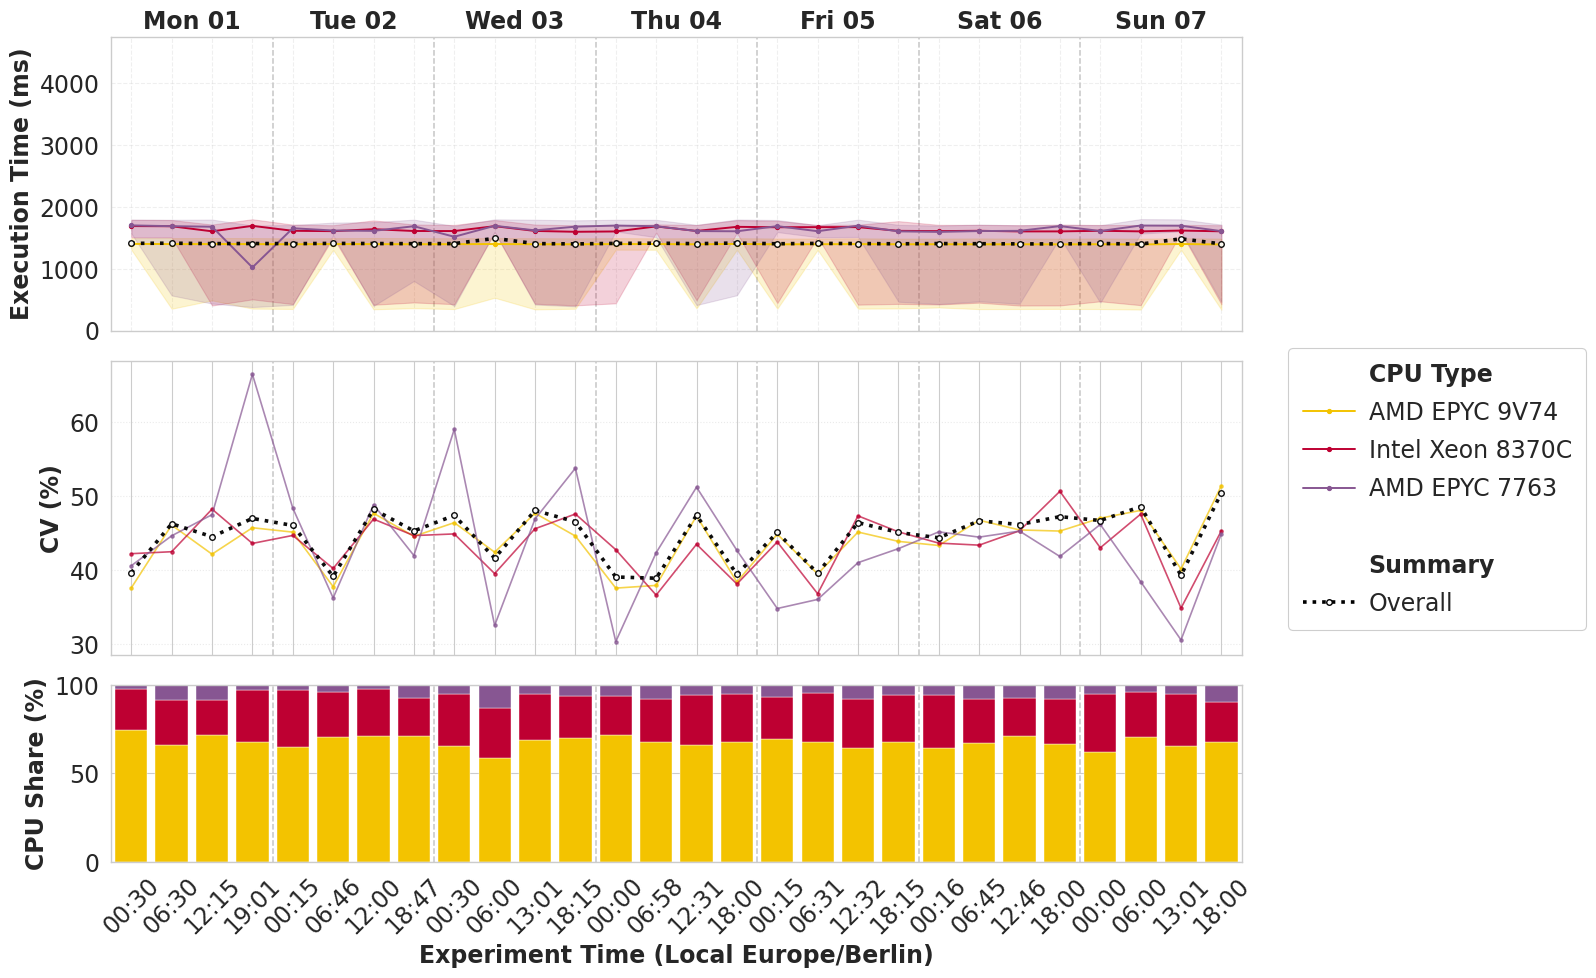

Saved: plots/stage_c/temporal_dynamics/azure/trend_aesCtr_azure_512mb.pdf


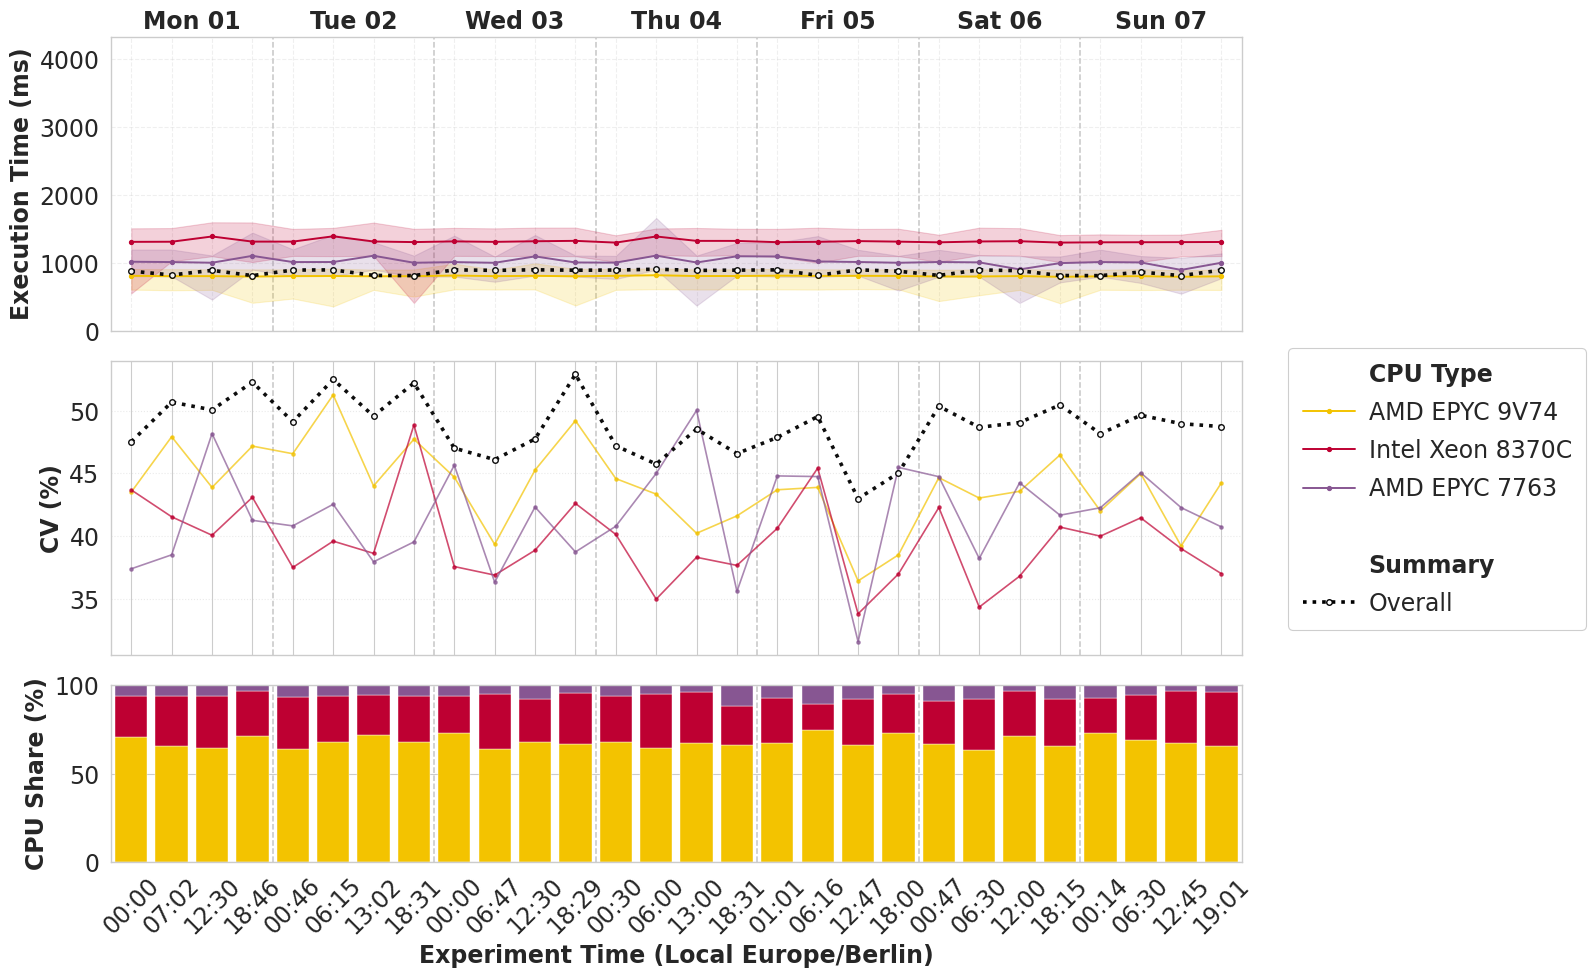

Saved: plots/stage_c/temporal_dynamics/azure/trend_json_azure_512mb.pdf


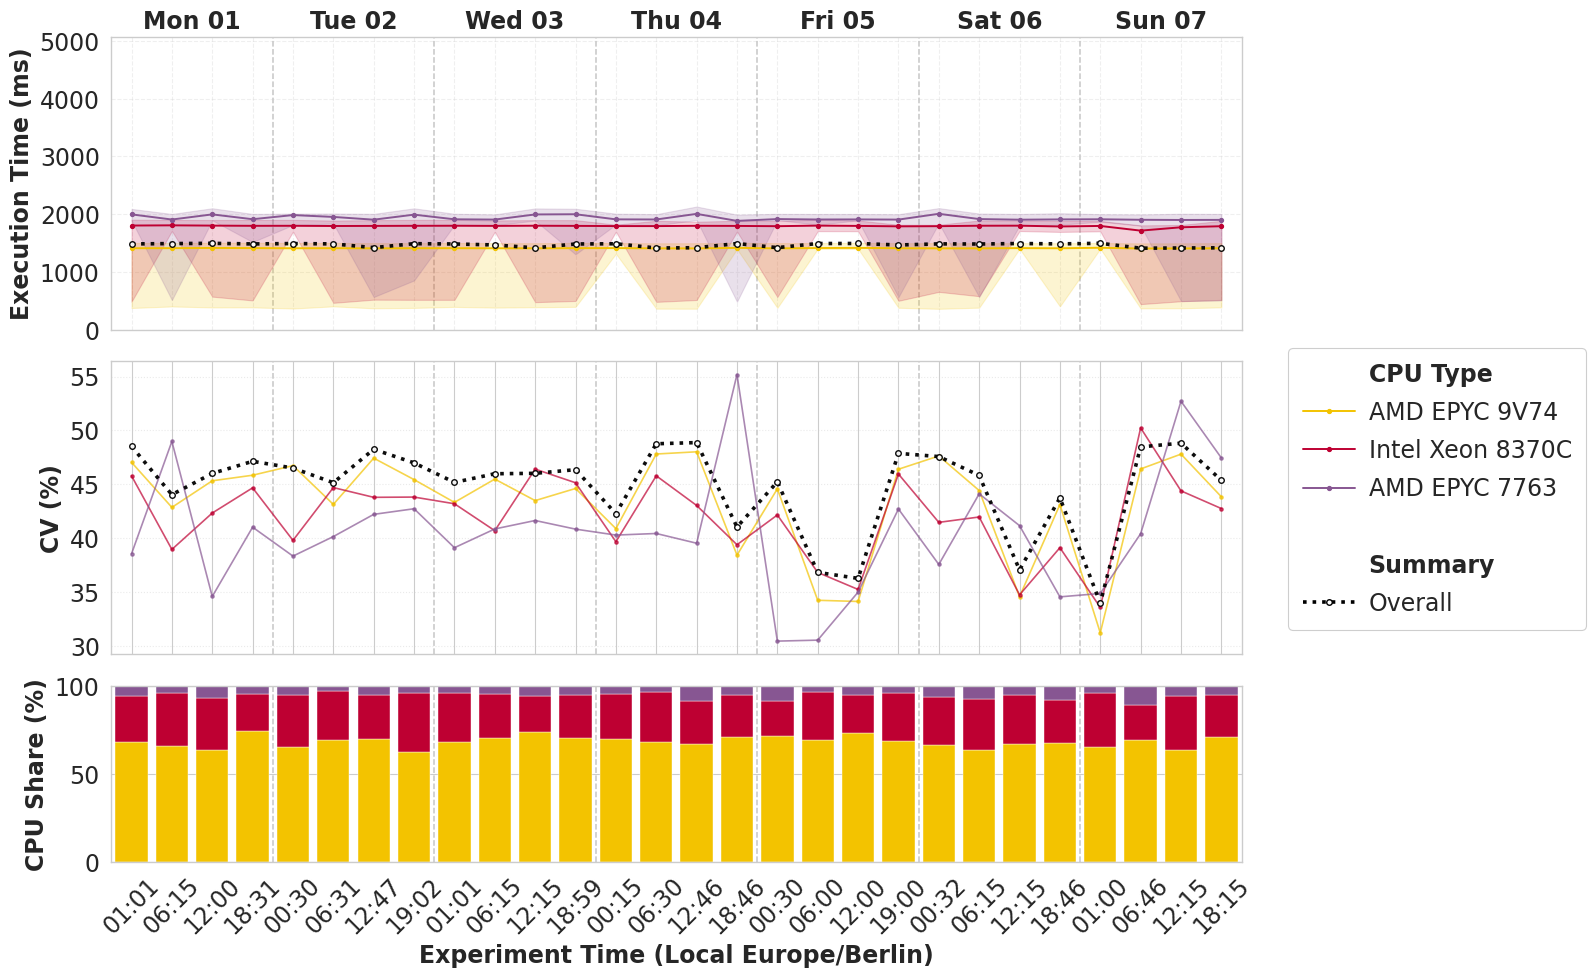

In [7]:
import os
from pathlib import Path
from typing import Optional, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import  get_cpu_palette

def _stats_by_slot(d: pd.DataFrame, metric: str, n_slots: int) -> pd.DataFrame:
    g = d.groupby("slot_idx")[metric]
    out = pd.DataFrame(
        {
            "median": g.median(),
            "p25": g.quantile(0.25),
            "p75": g.quantile(0.75),
            "mean": g.mean(),
            "std": g.std(ddof=1),
        }
    ).reindex(range(n_slots))

    with np.errstate(divide="ignore", invalid="ignore"):
        out["cv"] = (out["std"] / out["mean"]) * 100.0
    out["cv"] = out["cv"].replace([np.inf, -np.inf], np.nan)
    return out


def _day_bounds(local_ts: pd.DatetimeIndex) -> dict:
    bounds: dict = {}
    for i, day in enumerate(pd.Series(local_ts.date)):
        bounds.setdefault(day, []).append(i)
    return bounds


def _add_day_separators(ax: plt.Axes, bounds: dict) -> None:
    for idxs in bounds.values():
        if idxs and idxs[0] > 0:
            ax.axvline(idxs[0] - 0.5, color="gray", ls="--", lw=1.1, alpha=0.45, zorder=0)


def _make_right_legend(fig: plt.Figure, cpu_order: list[str], palette: dict, cpu_label: dict) -> None:
    hdr = Line2D([0], [0], color="none", lw=0)
    blank = Line2D([0], [0], color="none", lw=0)

    cpu_handles = [Line2D([0], [0], color=palette[c], lw=1.4, marker="o", ms=2.8) for c in cpu_order]
    cpu_labels = [cpu_label[c] for c in cpu_order]

    overall_handle = Line2D(
        [0], [0],
        color="black", ls=":", lw=2.6,
        marker="o", ms=4.0,
        mfc="white", mec="black", mew=1.0,
    )

    handles = [hdr] + cpu_handles + [blank, hdr, overall_handle]
    labels = ["CPU Type"] + cpu_labels + ["", "Summary", "Overall"]

    leg = fig.legend(
        handles, labels,
        loc="center left",
        bbox_to_anchor=(0.885, 0.50),
        ncol=1,
        frameon=True,
        framealpha=0.95,
        fontsize=17,
        handlelength=2.2,
        handletextpad=0.6,
        labelspacing=0.6,
        borderpad=0.6,
    )
    for t in leg.get_texts():
        if t.get_text() in {"CPU Type", "Summary"}:
            t.set_fontweight("bold")


def plot_temporal_dynamics(
    df: pd.DataFrame,                  # full (untrimmed) data
    provider: str,
    benchmark: str,
    memory_size: int = 512,
    save_path: Optional[Union[str, Path]] = None,
    show: bool = True,
    df_cv: Optional[pd.DataFrame] = None,   # <-- NEW: trimmed data for CV panel
) -> Optional[plt.Figure]:
    provider = str(provider).lower()

    if df_cv is None:
        df_cv = df  # fallback

    d_full = df[
        (df["provider"] == provider)
        & (df["memory_size_mb"] == memory_size)
        & (df["benchmark_type"] == benchmark)
    ].copy()

    d_cv = df_cv[
        (df_cv["provider"] == provider)
        & (df_cv["memory_size_mb"] == memory_size)
        & (df_cv["benchmark_type"] == benchmark)
    ].copy()

    metric = metric_for_benchmark(benchmark)

    def _prep(dd: pd.DataFrame) -> pd.DataFrame:
        dd["timestamp"] = pd.to_datetime(dd["timestamp"], utc=True)
        dd[metric] = pd.to_numeric(dd[metric], errors="coerce")
        return dd.dropna(subset=["timestamp", "cpu_type", metric])

    d_full = _prep(d_full)
    d_cv = _prep(d_cv)

    # Align slot index to FULL timeline (x-axis stays identical)
    unique_slots = pd.DatetimeIndex(sorted(d_full["timestamp"].unique()))
    slot_to_idx = {ts: i for i, ts in enumerate(unique_slots)}

    d_full["slot_idx"] = d_full["timestamp"].map(slot_to_idx)
    d_cv["slot_idx"] = d_cv["timestamp"].map(slot_to_idx)
    d_cv = d_cv.dropna(subset=["slot_idx"]).copy()
    d_cv["slot_idx"] = d_cv["slot_idx"].astype(int)

    n_slots = len(unique_slots)
    slots = np.arange(n_slots)

    tz = "Europe/Berlin" if provider == "azure" else "America/New_York"
    local_ts = unique_slots.tz_convert(tz)
    bounds = _day_bounds(local_ts)

    cpu_order = d_full["cpu_type"].value_counts().index.tolist()
    palette = get_cpu_palette(cpu_order, provider=provider)
    palette = {c: palette.get(c, "#333333") for c in cpu_order}

    # FIX: cpu_label should map to a string label, not a boolean
    cpu_label = {c: c for c in cpu_order}

    # --- stats: perf from FULL, CV from TRIMMED ---
    overall_perf = _stats_by_slot(d_full, metric, n_slots)
    per_cpu_perf = {c: _stats_by_slot(d_full[d_full["cpu_type"] == c], metric, n_slots) for c in cpu_order}

    overall_cv = _stats_by_slot(d_cv, metric, n_slots)
    per_cpu_cv = {c: _stats_by_slot(d_cv[d_cv["cpu_type"] == c], metric, n_slots) for c in cpu_order}

    # CPU share per slot should stay FULL (untrimmed)
    dist = d_full.groupby(["slot_idx", "cpu_type"]).size().unstack(fill_value=0)
    dist = dist.reindex(index=range(n_slots), fill_value=0).reindex(columns=cpu_order, fill_value=0)
    denom = dist.sum(axis=1).replace(0, np.nan)
    dist_pct = (dist.div(denom, axis=0) * 100.0).fillna(0.0)

    # ---- plotting block: only replace per_cpu/overall usage below ----
    fig, (ax_perf, ax_var, ax_share) = plt.subplots(
        3, 1, figsize=(15, 11), sharex=True, gridspec_kw={"height_ratios": [5, 5, 3]}
    )

    # ---- Performance (FULL) ----
    _add_day_separators(ax_perf, bounds)
    for c in cpu_order:
        s = per_cpu_perf[c]
        ax_perf.fill_between(slots, s["p25"], s["p75"], where=s["median"].notna(), alpha=0.18, color=palette[c], zorder=1)
        ax_perf.plot(slots, s["median"], color=palette[c], lw=1.4, marker="o", ms=2.8, zorder=2)

    ax_perf.plot(
        slots, overall_perf["median"],
        color="black", ls=":", lw=2.6, marker="o", ms=4.0,
        mfc="white", mec="black", mew=1.0, alpha=0.95, zorder=5,
    )
    ax_perf.set_ylabel("Execution Time (ms)", fontweight="bold", fontsize=17)
    ax_perf.grid(True, ls="--", alpha=0.30)
    ax_perf.set_xlim(-0.5, n_slots - 0.5)

    y_top = np.nanmax(np.r_[overall_perf["p75"].to_numpy(), d_full[metric].to_numpy()])
    if np.isfinite(y_top) and y_top > 0:
        ax_perf.set_ylim(0, y_top * 1.08)
        for day, idxs in sorted(bounds.items()):
            mid = (idxs[0] + idxs[-1]) / 2
            ax_perf.text(mid, ax_perf.get_ylim()[1] * 1.01, pd.Timestamp(day).strftime("%a %d"),
                         ha="center", va="bottom", fontsize=17, fontweight="bold")

    # ---- Variability (TRIMMED) ----
    _add_day_separators(ax_var, bounds)
    for c in cpu_order:
        y = per_cpu_cv[c]["cv"].to_numpy()
        if np.all(np.isnan(y)):
            continue
        ax_var.plot(slots, y, color=palette[c], lw=1.2, alpha=0.70)
        ax_var.plot(slots, y, lw=0, marker="o", ms=2.3, color=palette[c], alpha=0.70)

    ax_var.plot(
        slots, overall_cv["cv"],
        color="black", ls=":", lw=2.6, marker="o", ms=4.0,
        mfc="white", mec="black", mew=1.0, alpha=0.95, zorder=5,
    )
    ax_var.set_ylabel("CV (%)", fontweight="bold", fontsize=17)
    ax_var.grid(True, axis="y", ls=":", alpha=0.40)

    # ---- CPU share (FULL) ----
    _add_day_separators(ax_share, bounds)
    bottom = np.zeros(n_slots)
    for c in cpu_order:
        vals = dist_pct[c].to_numpy()
        ax_share.bar(slots, vals, bottom=bottom, width=0.8, color=palette[c], edgecolor="white", lw=0.3)
        bottom += vals

    ax_share.set_ylabel("CPU Share (%)", fontweight="bold", fontsize=17)
    ax_share.set_ylim(0, 100)
    ax_share.set_xticks(slots)
    ax_share.set_xticklabels(local_ts.strftime("%H:%M"), fontsize=17, rotation=45)
    ax_share.set_xlabel(f"Experiment Time (Local {tz})", fontweight="bold", fontsize=17)
    ax_share.grid(True, axis="x", ls=":", alpha=0.30)


    ax_perf.tick_params(axis="y", labelsize=17)
    ax_var.tick_params(axis="y", labelsize=17)
    ax_share.tick_params(axis="y", labelsize=17)



    _make_right_legend(fig, cpu_order, palette, cpu_label)
    plt.tight_layout(rect=[0.03, 0.05, 0.88, 0.95])

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, bbox_inches="tight")
        print(f"Saved: {save_path}")

    if show:
        plt.show()

    return fig




for provider in ["aws", "gcp", "alibaba", "azure"]:
    # for benchmark in ["gemm", "sha256", "gzip", "aesCtr", "json"]:
    for benchmark in ["gemm", "sha256", "gzip", "aesCtr", "json"]:
        plot_temporal_dynamics(
            df,                 
            df_cv=trimmed_df,        
            provider=provider,
            benchmark=benchmark,
            memory_size=512,
            save_path=Path(f"plots/stage_c/temporal_dynamics/{provider}") / f"trend_{benchmark}_{provider}_512mb.pdf",
            show=True,
        )

